## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

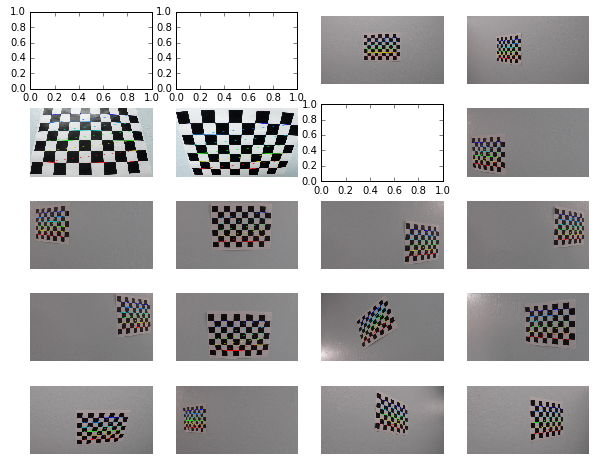

In [20]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5, 4, figsize=(10, 8))

# Step through the list and search for chessboard corners
for ax, fname in zip(axes.flat, images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        ax.axis('off')
        ax.imshow(img)

cv2.destroyAllWindows()

## Undirsorting images
Display the undistortion result on the examples of chessboard and real-world images and saving the undistortion parameters for future use:
* Camera Matrix
* Distortion coefficient

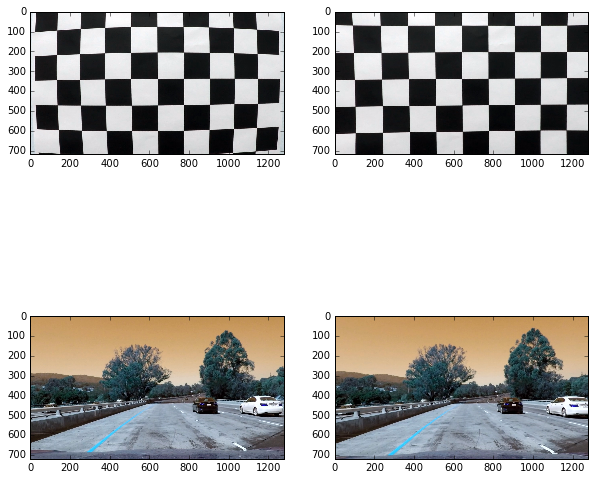

In [21]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

real_img = cv2.imread('./test_images/test1.jpg')
real_dst = cv2.undistort(real_img, mtx, dist, None, mtx)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [img, dst, real_img, real_dst]):
    ax.imshow(img)
    
pickle.dump(
    {
        'mtx': mtx,
        'dist': dist
    }, open('./calibration.p', 'wb')
)

## Transform perspective

In [22]:
def region_of_interest_coords(shape):
    width, height = shape[1], shape[0]
    
    vertical_mark = 0.63
    top, bottom, trapezoid_height = vertical_mark * height, height, (1 - vertical_mark) * height
    
    padding = 0.06
    bottom_left, bottom_right = padding * width, (1 - padding) * width
    
    trapezoid_ratio = 0.22
    trapezoid_length = bottom_right - bottom_left
    top_length = trapezoid_length * trapezoid_ratio
    trapezoid_offset = (trapezoid_length - top_length) / 2
    top_left, top_right = bottom_left + trapezoid_offset, bottom_right - trapezoid_offset
    
    trapezoid_coords = np.float32([
        [top_left, top], [top_right, top],
        [bottom_right, bottom], [bottom_left, bottom]
    ])
    
    return trapezoid_coords

In [23]:
def dst_coords(shape):
    width, height = shape[1], shape[0]
    offset = 0
    
    return np.float32([
        [offset, 0], [width - offset, 0],
        [width - offset, height], [offset, height] 
    ])

In [24]:
def draw_lines(img, coords):
    lines = zip(
        coords,
        np.insert(coords[:-1], 0, coords[-1], axis=0)
    )
        
    for x, y in lines:
        x = tuple(x)
        y = tuple(y)
        cv2.line(img, x, y, [255, 0, 0], 3)
        
    return img

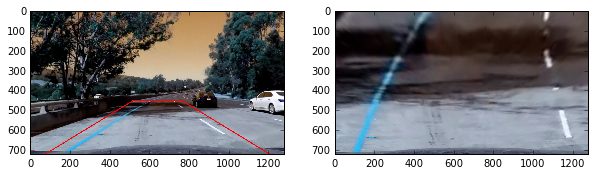

In [25]:
calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
mtx = calibration_parameters['mtx']
dist = calibration_parameters['dist']

lanes_image = cv2.imread('./test_images/test5.jpg')
undistorted = cv2.undistort(lanes_image, mtx, dist, None, mtx)
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

src = region_of_interest_coords(undistorted.shape)
dst = dst_coords(undistorted.shape)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(
    undistorted, M, 
    (undistorted.shape[1], undistorted.shape[0])
)

undistorted_lines = draw_lines(undistorted, src)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [undistorted_lines, warped]):
    ax.imshow(img)

##Color transformation

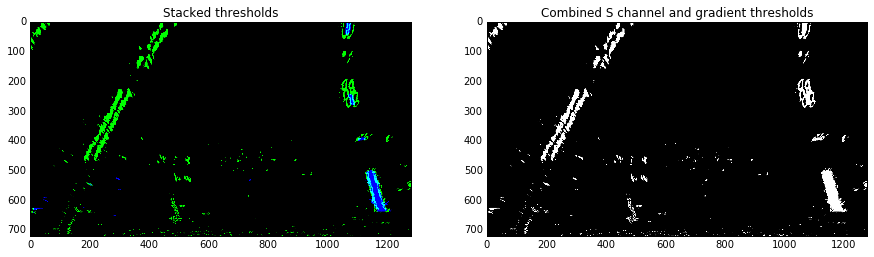

In [39]:
def color_transformation(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Tried L channel, and it actually works better
    s_channel = hls[:,:,1]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    # sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 190
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

# color_binary, combined_binary = color_transformation_udacity( cv2.imread('./test_images/test5.jpg') )
color_binary, combined_binary = color_transformation( warped )

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

##Finding lanes

In [40]:
def polyfit(binary_warped, xm_per_pix=1, ym_per_pix=1):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    # left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    # right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

##Calculating curvature

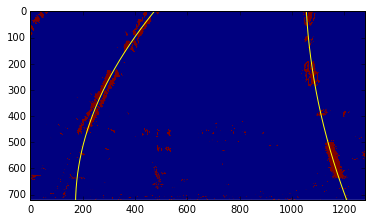

In [41]:
left_fit, right_fit = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)

def plot_fit(left_fit, right_fit, combined_binary):
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(combined_binary)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

plot_fit(left_fit, right_fit, combined_binary)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [42]:
def curvature_radius(y_eval, left_fit, right_fit, xm_per_pix=1.0, ym_per_pix=1.0):
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

##Entire pipeline

Left curve radius: 1860 m
Right curve radius: 2285 m


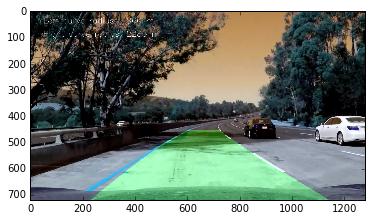

In [49]:
def detect_lanes(img):

    calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
    mtx = calibration_parameters['mtx']
    dist = calibration_parameters['dist']

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    src = region_of_interest_coords(undistorted.shape)
    dst = dst_coords(undistorted.shape)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective( undistorted, M, (undistorted.shape[1], undistorted.shape[0]) )

    color_binary, combined_binary = color_transformation(warped)

    left_fit, right_fit = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = np.max(ploty)
    left_curverad, right_curverad = curvature_radius(y_eval, left_fit, right_fit, xm_per_pix=3.7/700, ym_per_pix=30/720)
    
    return left_fit, right_fit, left_curverad, right_curverad

def draw_lanes(img, left_fit, right_fit, left_curverad, right_curverad):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    res_image = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    cv2.putText(res_image, 'Left curve radius: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    cv2.putText(res_image, 'Right curve radius: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    print('Left curve radius: {:.0f} m'.format(left_curverad))
    print('Right curve radius: {:.0f} m'.format(right_curverad))
    
    return res_image

class Buf(object):
    def __init__(self, value, length):
        self.buf = np.repeat(value, length)
        
    def append(self, item):
        self.buf = np.insert(self.buf[:-1], 0, item, axis=0)
        
class Bufs(object):
    def __init__(self, length):
        self.bufs = None
        self.length = length
    
    def append(self, items):
        if not self.bufs:
            self.bufs = [Buf(item, self.length) for item in items]
            return
        
        for buf, item in zip(self.bufs, items):
            buf.append(item)
    
    def average(self):
        return [
            np.average(buf.buf)
            for buf in self.bufs
        ]
    
bufs = Bufs(50)
def video_pipeline(img):
    left_fit, right_fit, left_curverad, right_curverad = detect_lanes(img)
    bufs.append([
        left_fit[0], left_fit[1], left_fit[2],
        right_fit[0], right_fit[1], right_fit[2], 
        left_curverad,
        right_curverad
    ])
    
    [left_fit[0], left_fit[1], left_fit[2],
    right_fit[0], right_fit[1], right_fit[2], 
    left_curverad,
    right_curverad] = bufs.average()
    
    res_image = draw_lanes(img, left_fit, right_fit, left_curverad, right_curverad)
    return res_image

res_image = video_pipeline(cv2.imread('./test_images/test5.jpg'))
plt.imshow(res_image)

##Video

In [47]:
from moviepy.editor import VideoFileClip
white_output = './output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Left curve radius: 1853 m
Right curve radius: 2293 m
[MoviePy] >>>> Building video ./output_video.mp4


[MoviePy] Writing video ./output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:12,  9.51it/s]

Left curve radius: 1845 m
Right curve radius: 2300 m


  0%|          | 2/1261 [00:00<02:19,  9.01it/s]

Left curve radius: 1838 m
Right curve radius: 2317 m


  0%|          | 4/1261 [00:00<02:07,  9.85it/s]

Left curve radius: 1829 m
Right curve radius: 2336 m
Left curve radius: 1820 m
Right curve radius: 2358 m


Left curve radius: 1810 m
Right curve radius: 2383 m


  0%|          | 6/1261 [00:00<01:59, 10.48it/s]

Left curve radius: 1801 m
Right curve radius: 2409 m
Left curve radius: 1794 m
Right curve radius: 2433 m


  1%|          | 8/1261 [00:00<01:52, 11.11it/s]

Left curve radius: 1788 m
Right curve radius: 2431 m


  1%|          | 10/1261 [00:00<01:48, 11.50it/s]

Left curve radius: 1784 m
Right curve radius: 2458 m
Left curve radius: 1781 m
Right curve radius: 2479 m


Left curve radius: 1777 m
Right curve radius: 2507 m


  1%|          | 12/1261 [00:01<01:46, 11.76it/s]

Left curve radius: 1778 m
Right curve radius: 2528 m
Left curve radius: 1788 m
Right curve radius: 2540 m


  1%|          | 14/1261 [00:01<01:44, 11.96it/s]

Left curve radius: 1790 m
Right curve radius: 2571 m


  1%|▏         | 16/1261 [00:01<01:43, 12.05it/s]

Left curve radius: 1792 m
Right curve radius: 2600 m
Left curve radius: 1795 m
Right curve radius: 2634 m


Left curve radius: 1794 m
Right curve radius: 2675 m


  1%|▏         | 18/1261 [00:01<01:42, 12.14it/s]

Left curve radius: 1796 m
Right curve radius: 2717 m
Left curve radius: 1799 m
Right curve radius: 2762 m


  2%|▏         | 20/1261 [00:01<01:39, 12.43it/s]

Left curve radius: 1808 m
Right curve radius: 2761 m


  2%|▏         | 22/1261 [00:01<01:39, 12.44it/s]

Left curve radius: 1834 m
Right curve radius: 2761 m
Left curve radius: 1860 m
Right curve radius: 2769 m


Left curve radius: 1888 m
Right curve radius: 2775 m


  2%|▏         | 24/1261 [00:01<01:39, 12.45it/s]

Left curve radius: 1906 m
Right curve radius: 2791 m
Left curve radius: 1914 m
Right curve radius: 2814 m


  2%|▏         | 26/1261 [00:02<01:38, 12.57it/s]

Left curve radius: 1918 m
Right curve radius: 2827 m


  2%|▏         | 28/1261 [00:02<01:42, 12.02it/s]

Left curve radius: 1919 m
Right curve radius: 2840 m
Left curve radius: 1925 m
Right curve radius: 2857 m


Left curve radius: 1929 m
Right curve radius: 2877 m


  2%|▏         | 30/1261 [00:02<01:44, 11.83it/s]

Left curve radius: 1924 m
Right curve radius: 2895 m
Left curve radius: 1918 m
Right curve radius: 2918 m


  3%|▎         | 32/1261 [00:02<01:42, 12.03it/s]

Left curve radius: 1908 m
Right curve radius: 2939 m


  3%|▎         | 34/1261 [00:02<01:47, 11.45it/s]

Left curve radius: 1901 m
Right curve radius: 2936 m
Left curve radius: 1892 m
Right curve radius: 2942 m


Left curve radius: 1884 m
Right curve radius: 2945 m


  3%|▎         | 36/1261 [00:03<01:47, 11.42it/s]

Left curve radius: 1873 m
Right curve radius: 2957 m
Left curve radius: 1860 m
Right curve radius: 2976 m


  3%|▎         | 38/1261 [00:03<01:44, 11.74it/s]

Left curve radius: 1847 m
Right curve radius: 2981 m


  3%|▎         | 40/1261 [00:03<01:41, 12.06it/s]

Left curve radius: 1832 m
Right curve radius: 2993 m
Left curve radius: 1819 m
Right curve radius: 3008 m


Left curve radius: 1806 m
Right curve radius: 3025 m


  3%|▎         | 42/1261 [00:03<01:39, 12.22it/s]

Left curve radius: 1792 m
Right curve radius: 3046 m
Left curve radius: 1779 m
Right curve radius: 3068 m


  3%|▎         | 44/1261 [00:03<01:37, 12.52it/s]

Left curve radius: 1766 m
Right curve radius: 3090 m


  4%|▎         | 46/1261 [00:03<01:36, 12.63it/s]

Left curve radius: 1753 m
Right curve radius: 3110 m
Left curve radius: 1745 m
Right curve radius: 3105 m


Left curve radius: 1736 m
Right curve radius: 3110 m


  4%|▍         | 48/1261 [00:03<01:40, 12.01it/s]

Left curve radius: 1726 m
Right curve radius: 3117 m
Left curve radius: 1719 m
Right curve radius: 3127 m


  4%|▍         | 50/1261 [00:04<01:40, 12.10it/s]

Left curve radius: 1718 m
Right curve radius: 3127 m


  4%|▍         | 52/1261 [00:04<01:39, 12.11it/s]

Left curve radius: 1719 m
Right curve radius: 3128 m
Left curve radius: 1722 m
Right curve radius: 3124 m


Left curve radius: 1730 m
Right curve radius: 3121 m


  4%|▍         | 54/1261 [00:04<01:41, 11.84it/s]

Left curve radius: 1740 m
Right curve radius: 3119 m
Left curve radius: 1750 m
Right curve radius: 3112 m


  4%|▍         | 56/1261 [00:04<01:40, 11.95it/s]

Left curve radius: 1763 m
Right curve radius: 3109 m


  5%|▍         | 58/1261 [00:04<01:39, 12.12it/s]

Left curve radius: 1777 m
Right curve radius: 3108 m
Left curve radius: 1791 m
Right curve radius: 3113 m


Left curve radius: 1801 m
Right curve radius: 3088 m


  5%|▍         | 60/1261 [00:04<01:39, 12.12it/s]

Left curve radius: 1810 m
Right curve radius: 3083 m
Left curve radius: 1819 m
Right curve radius: 3065 m


  5%|▍         | 62/1261 [00:05<01:43, 11.60it/s]

Left curve radius: 1819 m
Right curve radius: 3058 m


  5%|▌         | 64/1261 [00:05<01:46, 11.27it/s]

Left curve radius: 1809 m
Right curve radius: 3067 m
Left curve radius: 1805 m
Right curve radius: 3060 m


Left curve radius: 1801 m
Right curve radius: 3057 m


  5%|▌         | 66/1261 [00:05<01:51, 10.76it/s]

Left curve radius: 1798 m
Right curve radius: 3054 m
Left curve radius: 1797 m
Right curve radius: 3040 m


  5%|▌         | 68/1261 [00:05<01:48, 10.96it/s]

Left curve radius: 1791 m
Right curve radius: 3039 m


  6%|▌         | 70/1261 [00:05<01:45, 11.34it/s]

Left curve radius: 1783 m
Right curve radius: 3026 m
Left curve radius: 1769 m
Right curve radius: 3037 m


Left curve radius: 1747 m
Right curve radius: 3033 m


  6%|▌         | 72/1261 [00:06<01:42, 11.57it/s]

Left curve radius: 1726 m
Right curve radius: 3023 m
Left curve radius: 1703 m
Right curve radius: 3019 m


  6%|▌         | 74/1261 [00:06<01:40, 11.82it/s]

Left curve radius: 1692 m
Right curve radius: 3009 m


  6%|▌         | 76/1261 [00:06<01:38, 11.99it/s]

Left curve radius: 1691 m
Right curve radius: 2994 m
Left curve radius: 1699 m
Right curve radius: 2986 m


Left curve radius: 1711 m
Right curve radius: 2981 m


  6%|▌         | 78/1261 [00:06<01:43, 11.39it/s]

Left curve radius: 1726 m
Right curve radius: 2975 m
Left curve radius: 1766 m
Right curve radius: 2969 m


  6%|▋         | 80/1261 [00:06<01:41, 11.59it/s]

Left curve radius: 1814 m
Right curve radius: 2966 m


  7%|▋         | 82/1261 [00:06<01:38, 11.95it/s]

Left curve radius: 1861 m
Right curve radius: 2961 m
Left curve radius: 1909 m
Right curve radius: 2959 m


Left curve radius: 1950 m
Right curve radius: 2965 m


  7%|▋         | 84/1261 [00:07<01:38, 11.95it/s]

Left curve radius: 2002 m
Right curve radius: 2958 m
Left curve radius: 2048 m
Right curve radius: 2960 m


  7%|▋         | 86/1261 [00:07<01:36, 12.13it/s]

Left curve radius: 2084 m
Right curve radius: 2956 m


  7%|▋         | 88/1261 [00:07<01:36, 12.20it/s]

Left curve radius: 2110 m
Right curve radius: 2953 m
Left curve radius: 2125 m
Right curve radius: 2955 m


Left curve radius: 2139 m
Right curve radius: 2957 m


  7%|▋         | 90/1261 [00:07<01:33, 12.49it/s]

Left curve radius: 2147 m
Right curve radius: 2960 m
Left curve radius: 2155 m
Right curve radius: 2962 m


  7%|▋         | 92/1261 [00:07<01:32, 12.63it/s]

Left curve radius: 2167 m
Right curve radius: 2962 m


  7%|▋         | 94/1261 [00:07<01:30, 12.87it/s]

Left curve radius: 2175 m
Right curve radius: 2967 m
Left curve radius: 2181 m
Right curve radius: 2974 m


Left curve radius: 2188 m
Right curve radius: 2981 m


  8%|▊         | 96/1261 [00:08<01:29, 13.08it/s]

Left curve radius: 2203 m
Right curve radius: 2984 m
Left curve radius: 2212 m
Right curve radius: 2984 m


  8%|▊         | 98/1261 [00:08<01:29, 12.93it/s]

Left curve radius: 2221 m
Right curve radius: 2987 m


  8%|▊         | 100/1261 [00:08<01:29, 13.03it/s]

Left curve radius: 2227 m
Right curve radius: 2991 m
Left curve radius: 2234 m
Right curve radius: 2995 m


Left curve radius: 2239 m
Right curve radius: 2990 m


  8%|▊         | 102/1261 [00:08<01:29, 13.02it/s]

Left curve radius: 2237 m
Right curve radius: 2985 m
Left curve radius: 2233 m
Right curve radius: 2980 m


  8%|▊         | 104/1261 [00:08<01:28, 13.03it/s]

Left curve radius: 2229 m
Right curve radius: 2973 m


Left curve radius: 2227 m
Right curve radius: 2968 m


  8%|▊         | 106/1261 [00:08<01:42, 11.25it/s]

Left curve radius: 2218 m
Right curve radius: 2963 m


  9%|▊         | 108/1261 [00:09<01:43, 11.16it/s]

Left curve radius: 2207 m
Right curve radius: 2959 m
Left curve radius: 2193 m
Right curve radius: 2963 m


Left curve radius: 2186 m
Right curve radius: 2957 m


  9%|▊         | 110/1261 [00:09<01:42, 11.24it/s]

Left curve radius: 2176 m
Right curve radius: 2946 m
Left curve radius: 2167 m
Right curve radius: 2947 m


  9%|▉         | 112/1261 [00:09<01:39, 11.60it/s]

Left curve radius: 2162 m
Right curve radius: 2943 m


  9%|▉         | 114/1261 [00:09<01:37, 11.73it/s]

Left curve radius: 2155 m
Right curve radius: 2941 m
Left curve radius: 2153 m
Right curve radius: 2921 m


Left curve radius: 2147 m
Right curve radius: 2902 m


  9%|▉         | 116/1261 [00:09<01:37, 11.75it/s]

Left curve radius: 2140 m
Right curve radius: 2879 m
Left curve radius: 2133 m
Right curve radius: 2864 m


  9%|▉         | 118/1261 [00:09<01:38, 11.56it/s]

Left curve radius: 2126 m
Right curve radius: 2834 m


 10%|▉         | 120/1261 [00:10<01:36, 11.81it/s]

Left curve radius: 2120 m
Right curve radius: 2817 m
Left curve radius: 2115 m
Right curve radius: 2820 m


Left curve radius: 2100 m
Right curve radius: 2827 m


 10%|▉         | 122/1261 [00:10<01:35, 11.91it/s]

Left curve radius: 2086 m
Right curve radius: 2828 m
Left curve radius: 2070 m
Right curve radius: 2826 m


 10%|▉         | 124/1261 [00:10<01:34, 12.09it/s]

Left curve radius: 2052 m
Right curve radius: 2827 m


 10%|▉         | 126/1261 [00:10<01:31, 12.36it/s]

Left curve radius: 2033 m
Right curve radius: 2822 m
Left curve radius: 2011 m
Right curve radius: 2822 m


Left curve radius: 1989 m
Right curve radius: 2824 m


 10%|█         | 128/1261 [00:10<01:31, 12.38it/s]

Left curve radius: 1960 m
Right curve radius: 2825 m
Left curve radius: 1907 m
Right curve radius: 2826 m


 10%|█         | 130/1261 [00:10<01:33, 12.15it/s]

Left curve radius: 1857 m
Right curve radius: 2829 m


 10%|█         | 132/1261 [00:11<01:32, 12.15it/s]

Left curve radius: 1809 m
Right curve radius: 2830 m
Left curve radius: 1765 m
Right curve radius: 2831 m


Left curve radius: 1725 m
Right curve radius: 2847 m


 11%|█         | 134/1261 [00:11<01:31, 12.28it/s]

Left curve radius: 1678 m
Right curve radius: 2846 m
Left curve radius: 1639 m
Right curve radius: 2849 m


 11%|█         | 136/1261 [00:11<01:30, 12.41it/s]

Left curve radius: 1612 m
Right curve radius: 2849 m


 11%|█         | 138/1261 [00:11<01:29, 12.58it/s]

Left curve radius: 1598 m
Right curve radius: 2850 m
Left curve radius: 1597 m
Right curve radius: 2862 m


Left curve radius: 1598 m
Right curve radius: 2853 m


 11%|█         | 140/1261 [00:11<01:29, 12.54it/s]

Left curve radius: 1605 m
Right curve radius: 2856 m
Left curve radius: 1617 m
Right curve radius: 2859 m


 11%|█▏        | 142/1261 [00:11<01:28, 12.59it/s]

Left curve radius: 1626 m
Right curve radius: 2861 m


 11%|█▏        | 144/1261 [00:11<01:28, 12.56it/s]

Left curve radius: 1634 m
Right curve radius: 2857 m
Left curve radius: 1642 m
Right curve radius: 2861 m


Left curve radius: 1648 m
Right curve radius: 2862 m


 12%|█▏        | 146/1261 [00:12<01:31, 12.17it/s]

Left curve radius: 1644 m
Right curve radius: 2858 m
Left curve radius: 1651 m
Right curve radius: 2862 m


 12%|█▏        | 148/1261 [00:12<01:31, 12.12it/s]

Left curve radius: 1654 m
Right curve radius: 2860 m


 12%|█▏        | 150/1261 [00:12<01:35, 11.65it/s]

Left curve radius: 1656 m
Right curve radius: 2855 m
Left curve radius: 1658 m
Right curve radius: 2851 m


Left curve radius: 1663 m
Right curve radius: 2849 m


 12%|█▏        | 152/1261 [00:12<01:36, 11.45it/s]

Left curve radius: 1670 m
Right curve radius: 2852 m
Left curve radius: 1674 m
Right curve radius: 2857 m


 12%|█▏        | 154/1261 [00:12<01:35, 11.59it/s]

Left curve radius: 1680 m
Right curve radius: 2864 m


 12%|█▏        | 156/1261 [00:13<01:33, 11.78it/s]

Left curve radius: 1683 m
Right curve radius: 2873 m
Left curve radius: 1689 m
Right curve radius: 2880 m


Left curve radius: 1692 m
Right curve radius: 2885 m


 13%|█▎        | 158/1261 [00:13<01:32, 11.87it/s]

Left curve radius: 1695 m
Right curve radius: 2900 m
Left curve radius: 1696 m
Right curve radius: 2898 m


 13%|█▎        | 160/1261 [00:13<01:30, 12.14it/s]

Left curve radius: 1695 m
Right curve radius: 2902 m


 13%|█▎        | 162/1261 [00:13<01:30, 12.13it/s]

Left curve radius: 1695 m
Right curve radius: 2898 m
Left curve radius: 1693 m
Right curve radius: 2909 m


Left curve radius: 1694 m
Right curve radius: 2909 m


 13%|█▎        | 164/1261 [00:13<01:30, 12.17it/s]

Left curve radius: 1691 m
Right curve radius: 2921 m
Left curve radius: 1698 m
Right curve radius: 2933 m


 13%|█▎        | 166/1261 [00:13<01:30, 12.16it/s]

Left curve radius: 1703 m
Right curve radius: 2945 m


 13%|█▎        | 168/1261 [00:13<01:29, 12.24it/s]

Left curve radius: 1705 m
Right curve radius: 2964 m
Left curve radius: 1713 m
Right curve radius: 2985 m


Left curve radius: 1721 m
Right curve radius: 3004 m


 13%|█▎        | 170/1261 [00:14<01:28, 12.26it/s]

Left curve radius: 1733 m
Right curve radius: 3018 m
Left curve radius: 1745 m
Right curve radius: 3009 m


 14%|█▎        | 172/1261 [00:14<01:27, 12.43it/s]

Left curve radius: 1756 m
Right curve radius: 3017 m


 14%|█▍        | 174/1261 [00:14<01:27, 12.47it/s]

Left curve radius: 1767 m
Right curve radius: 3016 m
Left curve radius: 1775 m
Right curve radius: 3015 m


Left curve radius: 1782 m
Right curve radius: 3012 m


 14%|█▍        | 176/1261 [00:14<01:26, 12.49it/s]

Left curve radius: 1783 m
Right curve radius: 3007 m
Left curve radius: 1789 m
Right curve radius: 2998 m


 14%|█▍        | 178/1261 [00:14<01:28, 12.19it/s]

Left curve radius: 1797 m
Right curve radius: 2989 m


 14%|█▍        | 180/1261 [00:14<01:29, 12.04it/s]

Left curve radius: 1806 m
Right curve radius: 2980 m
Left curve radius: 1811 m
Right curve radius: 2970 m


Left curve radius: 1811 m
Right curve radius: 2959 m


 14%|█▍        | 182/1261 [00:15<01:32, 11.63it/s]

Left curve radius: 1813 m
Right curve radius: 2947 m
Left curve radius: 1811 m
Right curve radius: 2929 m


 15%|█▍        | 184/1261 [00:15<01:30, 11.91it/s]

Left curve radius: 1804 m
Right curve radius: 2933 m


 15%|█▍        | 186/1261 [00:15<01:29, 11.95it/s]

Left curve radius: 1793 m
Right curve radius: 2931 m
Left curve radius: 1778 m
Right curve radius: 2929 m


Left curve radius: 1763 m
Right curve radius: 2921 m


 15%|█▍        | 188/1261 [00:15<01:28, 12.14it/s]

Left curve radius: 1744 m
Right curve radius: 2913 m
Left curve radius: 1729 m
Right curve radius: 2923 m


 15%|█▌        | 190/1261 [00:15<01:27, 12.24it/s]

Left curve radius: 1712 m
Right curve radius: 2919 m


 15%|█▌        | 192/1261 [00:15<01:25, 12.43it/s]

Left curve radius: 1691 m
Right curve radius: 2919 m
Left curve radius: 1668 m
Right curve radius: 2919 m


Left curve radius: 1651 m
Right curve radius: 2920 m


 15%|█▌        | 194/1261 [00:16<01:25, 12.45it/s]

Left curve radius: 1638 m
Right curve radius: 2914 m
Left curve radius: 1625 m
Right curve radius: 2888 m


 16%|█▌        | 196/1261 [00:16<01:25, 12.53it/s]

Left curve radius: 1613 m
Right curve radius: 2888 m


 16%|█▌        | 198/1261 [00:16<01:23, 12.68it/s]

Left curve radius: 1602 m
Right curve radius: 2885 m
Left curve radius: 1597 m
Right curve radius: 2886 m


Left curve radius: 1596 m
Right curve radius: 2880 m


 16%|█▌        | 200/1261 [00:16<01:23, 12.73it/s]

Left curve radius: 1594 m
Right curve radius: 2879 m
Left curve radius: 1600 m
Right curve radius: 2883 m


 16%|█▌        | 202/1261 [00:16<01:23, 12.62it/s]

Left curve radius: 1603 m
Right curve radius: 2884 m


 16%|█▌        | 204/1261 [00:16<01:23, 12.67it/s]

Left curve radius: 1601 m
Right curve radius: 2883 m
Left curve radius: 1595 m
Right curve radius: 2883 m


Left curve radius: 1589 m
Right curve radius: 2878 m


 16%|█▋        | 206/1261 [00:17<01:23, 12.62it/s]

Left curve radius: 1582 m
Right curve radius: 2873 m
Left curve radius: 1574 m
Right curve radius: 2868 m


 16%|█▋        | 208/1261 [00:17<01:22, 12.70it/s]

Left curve radius: 1568 m
Right curve radius: 2841 m


 17%|█▋        | 210/1261 [00:17<01:22, 12.69it/s]

Left curve radius: 1561 m
Right curve radius: 2842 m
Left curve radius: 1557 m
Right curve radius: 2836 m


Left curve radius: 1554 m
Right curve radius: 2831 m


 17%|█▋        | 212/1261 [00:17<01:26, 12.10it/s]

Left curve radius: 1550 m
Right curve radius: 2814 m
Left curve radius: 1549 m
Right curve radius: 2797 m


 17%|█▋        | 214/1261 [00:17<01:29, 11.73it/s]

Left curve radius: 1547 m
Right curve radius: 2797 m


 17%|█▋        | 216/1261 [00:17<01:31, 11.37it/s]

Left curve radius: 1539 m
Right curve radius: 2798 m
Left curve radius: 1531 m
Right curve radius: 2800 m


Left curve radius: 1525 m
Right curve radius: 2790 m


 17%|█▋        | 218/1261 [00:18<01:32, 11.31it/s]

Left curve radius: 1517 m
Right curve radius: 2785 m
Left curve radius: 1509 m
Right curve radius: 2778 m


 17%|█▋        | 220/1261 [00:18<01:28, 11.73it/s]

Left curve radius: 1501 m
Right curve radius: 2753 m


 18%|█▊        | 222/1261 [00:18<01:27, 11.84it/s]

Left curve radius: 1492 m
Right curve radius: 2752 m
Left curve radius: 1486 m
Right curve radius: 2742 m


Left curve radius: 1481 m
Right curve radius: 2756 m


 18%|█▊        | 224/1261 [00:18<01:26, 11.96it/s]

Left curve radius: 1478 m
Right curve radius: 2766 m
Left curve radius: 1478 m
Right curve radius: 2771 m


 18%|█▊        | 226/1261 [00:18<01:26, 12.00it/s]

Left curve radius: 1484 m
Right curve radius: 2785 m


 18%|█▊        | 228/1261 [00:18<01:25, 12.05it/s]

Left curve radius: 1489 m
Right curve radius: 2803 m
Left curve radius: 1491 m
Right curve radius: 2824 m


Left curve radius: 1489 m
Right curve radius: 2843 m


 18%|█▊        | 230/1261 [00:19<01:29, 11.46it/s]

Left curve radius: 1494 m
Right curve radius: 2866 m
Left curve radius: 1503 m
Right curve radius: 2885 m


 18%|█▊        | 232/1261 [00:19<01:26, 11.86it/s]

Left curve radius: 1512 m
Right curve radius: 2902 m


 19%|█▊        | 234/1261 [00:19<01:24, 12.15it/s]

Left curve radius: 1527 m
Right curve radius: 2896 m
Left curve radius: 1543 m
Right curve radius: 2901 m


Left curve radius: 1561 m
Right curve radius: 2896 m


 19%|█▊        | 236/1261 [00:19<01:23, 12.29it/s]

Left curve radius: 1577 m
Right curve radius: 2893 m
Left curve radius: 1593 m
Right curve radius: 2883 m


 19%|█▉        | 238/1261 [00:19<01:22, 12.35it/s]

Left curve radius: 1611 m
Right curve radius: 2875 m


 19%|█▉        | 240/1261 [00:19<01:21, 12.49it/s]

Left curve radius: 1625 m
Right curve radius: 2866 m
Left curve radius: 1639 m
Right curve radius: 2861 m


Left curve radius: 1650 m
Right curve radius: 2853 m


 19%|█▉        | 242/1261 [00:20<01:21, 12.44it/s]

Left curve radius: 1663 m
Right curve radius: 2843 m
Left curve radius: 1674 m
Right curve radius: 2836 m


 19%|█▉        | 244/1261 [00:20<01:25, 11.96it/s]

Left curve radius: 1684 m
Right curve radius: 2825 m


 20%|█▉        | 246/1261 [00:20<01:25, 11.88it/s]

Left curve radius: 1693 m
Right curve radius: 2821 m
Left curve radius: 1697 m
Right curve radius: 2827 m


Left curve radius: 1698 m
Right curve radius: 2823 m


 20%|█▉        | 248/1261 [00:20<01:29, 11.35it/s]

Left curve radius: 1695 m
Right curve radius: 2817 m
Left curve radius: 1687 m
Right curve radius: 2811 m


 20%|█▉        | 250/1261 [00:20<01:29, 11.31it/s]

Left curve radius: 1682 m
Right curve radius: 2806 m


 20%|█▉        | 252/1261 [00:20<01:27, 11.48it/s]

Left curve radius: 1670 m
Right curve radius: 2808 m
Left curve radius: 1665 m
Right curve radius: 2806 m


Left curve radius: 1664 m
Right curve radius: 2803 m


 20%|██        | 254/1261 [00:21<01:25, 11.81it/s]

Left curve radius: 1669 m
Right curve radius: 2801 m
Left curve radius: 1674 m
Right curve radius: 2801 m


 20%|██        | 256/1261 [00:21<01:21, 12.29it/s]

Left curve radius: 1678 m
Right curve radius: 2799 m


 20%|██        | 258/1261 [00:21<01:23, 12.01it/s]

Left curve radius: 1684 m
Right curve radius: 2775 m
Left curve radius: 1692 m
Right curve radius: 2780 m


Left curve radius: 1698 m
Right curve radius: 2785 m


 21%|██        | 260/1261 [00:21<01:23, 12.04it/s]

Left curve radius: 1702 m
Right curve radius: 2783 m
Left curve radius: 1706 m
Right curve radius: 2777 m


 21%|██        | 262/1261 [00:21<01:22, 12.11it/s]

Left curve radius: 1717 m
Right curve radius: 2771 m


 21%|██        | 264/1261 [00:21<01:21, 12.17it/s]

Left curve radius: 1732 m
Right curve radius: 2773 m
Left curve radius: 1747 m
Right curve radius: 2769 m


Left curve radius: 1761 m
Right curve radius: 2762 m


 21%|██        | 266/1261 [00:22<01:21, 12.16it/s]

Left curve radius: 1773 m
Right curve radius: 2755 m
Left curve radius: 1785 m
Right curve radius: 2751 m


 21%|██▏       | 268/1261 [00:22<01:19, 12.42it/s]

Left curve radius: 1796 m
Right curve radius: 2738 m


 21%|██▏       | 270/1261 [00:22<01:19, 12.53it/s]

Left curve radius: 1808 m
Right curve radius: 2711 m
Left curve radius: 1818 m
Right curve radius: 2704 m


Left curve radius: 1826 m
Right curve radius: 2711 m


 22%|██▏       | 272/1261 [00:22<01:20, 12.34it/s]

Left curve radius: 1831 m
Right curve radius: 2719 m
Left curve radius: 1832 m
Right curve radius: 2712 m


 22%|██▏       | 274/1261 [00:22<01:19, 12.49it/s]

Left curve radius: 1834 m
Right curve radius: 2707 m


 22%|██▏       | 276/1261 [00:22<01:19, 12.34it/s]

Left curve radius: 1841 m
Right curve radius: 2712 m
Left curve radius: 1847 m
Right curve radius: 2714 m


Left curve radius: 1851 m
Right curve radius: 2717 m


 22%|██▏       | 278/1261 [00:23<01:22, 11.91it/s]

Left curve radius: 1854 m
Right curve radius: 2716 m
Left curve radius: 1865 m
Right curve radius: 2715 m


 22%|██▏       | 280/1261 [00:23<01:20, 12.19it/s]

Left curve radius: 1865 m
Right curve radius: 2708 m


 22%|██▏       | 282/1261 [00:23<01:23, 11.75it/s]

Left curve radius: 1883 m
Right curve radius: 2675 m
Left curve radius: 1894 m
Right curve radius: 2652 m


Left curve radius: 1899 m
Right curve radius: 2663 m


 23%|██▎       | 284/1261 [00:23<01:23, 11.64it/s]

Left curve radius: 1907 m
Right curve radius: 2663 m
Left curve radius: 1916 m
Right curve radius: 2670 m


 23%|██▎       | 286/1261 [00:23<01:22, 11.87it/s]

Left curve radius: 1942 m
Right curve radius: 2671 m


 23%|██▎       | 288/1261 [00:23<01:20, 12.05it/s]

Left curve radius: 1991 m
Right curve radius: 2679 m
Left curve radius: 2020 m
Right curve radius: 2695 m


Left curve radius: 2046 m
Right curve radius: 2714 m


 23%|██▎       | 290/1261 [00:24<01:19, 12.22it/s]

Left curve radius: 2080 m
Right curve radius: 2735 m
Left curve radius: 2116 m
Right curve radius: 2756 m


 23%|██▎       | 292/1261 [00:24<01:17, 12.50it/s]

Left curve radius: 2147 m
Right curve radius: 2772 m


 23%|██▎       | 294/1261 [00:24<01:18, 12.30it/s]

Left curve radius: 2202 m
Right curve radius: 2753 m
Left curve radius: 2255 m
Right curve radius: 2741 m


Left curve radius: 2304 m
Right curve radius: 2748 m


 23%|██▎       | 296/1261 [00:24<01:18, 12.30it/s]

Left curve radius: 2356 m
Right curve radius: 2758 m
Left curve radius: 2401 m
Right curve radius: 2773 m


 24%|██▎       | 298/1261 [00:24<01:17, 12.41it/s]

Left curve radius: 2445 m
Right curve radius: 2781 m


 24%|██▍       | 300/1261 [00:24<01:17, 12.44it/s]

Left curve radius: 2529 m
Right curve radius: 2801 m
Left curve radius: 2607 m
Right curve radius: 2829 m


Left curve radius: 2678 m
Right curve radius: 2865 m


 24%|██▍       | 302/1261 [00:25<01:16, 12.49it/s]

Left curve radius: 2758 m
Right curve radius: 2899 m
Left curve radius: 2825 m
Right curve radius: 2934 m


 24%|██▍       | 304/1261 [00:25<01:17, 12.29it/s]

Left curve radius: 2900 m
Right curve radius: 2965 m


 24%|██▍       | 306/1261 [00:25<01:18, 12.24it/s]

Left curve radius: 3163 m
Right curve radius: 2937 m
Left curve radius: 3459 m
Right curve radius: 2919 m


Left curve radius: 3546 m
Right curve radius: 2960 m


 24%|██▍       | 308/1261 [00:25<01:17, 12.26it/s]

Left curve radius: 3623 m
Right curve radius: 3045 m
Left curve radius: 3699 m
Right curve radius: 3127 m


 25%|██▍       | 310/1261 [00:25<01:19, 12.02it/s]

Left curve radius: 3843 m
Right curve radius: 3186 m


 25%|██▍       | 312/1261 [00:25<01:21, 11.70it/s]

Left curve radius: 5079 m
Right curve radius: 3272 m
Left curve radius: 5431 m
Right curve radius: 3429 m


Left curve radius: 5577 m
Right curve radius: 3566 m


 25%|██▍       | 314/1261 [00:26<01:22, 11.44it/s]

Left curve radius: 5729 m
Right curve radius: 3700 m


 25%|██▌       | 316/1261 [00:26<01:25, 11.08it/s]

Left curve radius: 5903 m
Right curve radius: 3833 m
Left curve radius: 6608 m
Right curve radius: 3933 m


Left curve radius: 6777 m
Right curve radius: 3911 m


 25%|██▌       | 318/1261 [00:26<01:25, 11.07it/s]

Left curve radius: 6931 m
Right curve radius: 3898 m
Left curve radius: 7203 m
Right curve radius: 3914 m


 25%|██▌       | 320/1261 [00:26<01:22, 11.42it/s]

Left curve radius: 7474 m
Right curve radius: 3930 m


 26%|██▌       | 322/1261 [00:26<01:19, 11.79it/s]

Left curve radius: 8462 m
Right curve radius: 3966 m
Left curve radius: 8755 m
Right curve radius: 3977 m


Left curve radius: 8898 m
Right curve radius: 4002 m


 26%|██▌       | 324/1261 [00:26<01:18, 11.89it/s]

Left curve radius: 9086 m
Right curve radius: 4031 m
Left curve radius: 9451 m
Right curve radius: 4092 m


 26%|██▌       | 326/1261 [00:27<01:16, 12.17it/s]

Left curve radius: 9732 m
Right curve radius: 4148 m


 26%|██▌       | 328/1261 [00:27<01:15, 12.34it/s]

Left curve radius: 10103 m
Right curve radius: 4198 m
Left curve radius: 10337 m
Right curve radius: 4247 m


Left curve radius: 10423 m
Right curve radius: 4219 m


 26%|██▌       | 330/1261 [00:27<01:19, 11.66it/s]

Left curve radius: 10501 m
Right curve radius: 4198 m
Left curve radius: 10740 m
Right curve radius: 4250 m


 26%|██▋       | 332/1261 [00:27<01:19, 11.66it/s]

Left curve radius: 11293 m
Right curve radius: 4296 m


 26%|██▋       | 334/1261 [00:27<01:18, 11.74it/s]

Left curve radius: 14448 m
Right curve radius: 4349 m
Left curve radius: 15457 m
Right curve radius: 4364 m


Left curve radius: 15721 m
Right curve radius: 4420 m


 27%|██▋       | 336/1261 [00:27<01:17, 11.91it/s]

Left curve radius: 16050 m
Right curve radius: 4546 m
Left curve radius: 17023 m
Right curve radius: 4782 m


 27%|██▋       | 338/1261 [00:28<01:15, 12.18it/s]

Left curve radius: 18360 m
Right curve radius: 4999 m


 27%|██▋       | 340/1261 [00:28<01:14, 12.35it/s]

Left curve radius: 21901 m
Right curve radius: 5307 m
Left curve radius: 22461 m
Right curve radius: 5494 m


Left curve radius: 24047 m
Right curve radius: 5523 m


 27%|██▋       | 342/1261 [00:28<01:18, 11.69it/s]

Left curve radius: 24120 m
Right curve radius: 5534 m


 27%|██▋       | 344/1261 [00:28<01:19, 11.56it/s]

Left curve radius: 24233 m
Right curve radius: 5619 m
Left curve radius: 24385 m
Right curve radius: 5663 m


Left curve radius: 24705 m
Right curve radius: 5805 m


 27%|██▋       | 346/1261 [00:28<01:21, 11.22it/s]

Left curve radius: 25088 m
Right curve radius: 5891 m


 28%|██▊       | 348/1261 [00:28<01:23, 10.99it/s]

Left curve radius: 28923 m
Right curve radius: 6066 m
Left curve radius: 29191 m
Right curve radius: 6318 m


Left curve radius: 29508 m
Right curve radius: 6714 m


 28%|██▊       | 350/1261 [00:29<01:23, 10.93it/s]

Left curve radius: 29862 m
Right curve radius: 7037 m
Left curve radius: 30197 m
Right curve radius: 7399 m


 28%|██▊       | 352/1261 [00:29<01:19, 11.49it/s]

Left curve radius: 31712 m
Right curve radius: 7635 m


 28%|██▊       | 354/1261 [00:29<01:15, 11.94it/s]

Left curve radius: 33070 m
Right curve radius: 7598 m
Left curve radius: 33780 m
Right curve radius: 7558 m


Left curve radius: 33720 m
Right curve radius: 7619 m


 28%|██▊       | 356/1261 [00:29<01:13, 12.29it/s]

Left curve radius: 33734 m
Right curve radius: 7672 m
Left curve radius: 33760 m
Right curve radius: 7688 m


 28%|██▊       | 358/1261 [00:29<01:12, 12.40it/s]

Left curve radius: 34509 m
Right curve radius: 7647 m


 29%|██▊       | 360/1261 [00:29<01:11, 12.55it/s]

Left curve radius: 35581 m
Right curve radius: 7661 m
Left curve radius: 36484 m
Right curve radius: 7741 m


Left curve radius: 36088 m
Right curve radius: 7809 m


 29%|██▊       | 362/1261 [00:30<01:10, 12.71it/s]

Left curve radius: 37067 m
Right curve radius: 7799 m
Left curve radius: 44525 m
Right curve radius: 7789 m


 29%|██▉       | 364/1261 [00:30<01:09, 12.99it/s]

Left curve radius: 44538 m
Right curve radius: 7786 m


 29%|██▉       | 366/1261 [00:30<01:08, 13.03it/s]

Left curve radius: 44409 m
Right curve radius: 7640 m
Left curve radius: 43731 m
Right curve radius: 7531 m


Left curve radius: 43611 m
Right curve radius: 7650 m


 29%|██▉       | 368/1261 [00:30<01:08, 13.12it/s]

Left curve radius: 43488 m
Right curve radius: 7754 m
Left curve radius: 43260 m
Right curve radius: 7874 m


 29%|██▉       | 370/1261 [00:30<01:13, 12.06it/s]

Left curve radius: 43036 m
Right curve radius: 8065 m


Left curve radius: 42081 m
Right curve radius: 8282 m


 30%|██▉       | 372/1261 [00:30<01:20, 11.06it/s]

Left curve radius: 41823 m
Right curve radius: 8756 m
Left curve radius: 41720 m
Right curve radius: 9391 m


 30%|██▉       | 374/1261 [00:31<01:18, 11.31it/s]

Left curve radius: 41597 m
Right curve radius: 10054 m


 30%|██▉       | 376/1261 [00:31<01:16, 11.62it/s]

Left curve radius: 41315 m
Right curve radius: 10465 m
Left curve radius: 41191 m
Right curve radius: 10946 m


Left curve radius: 40899 m
Right curve radius: 10878 m


 30%|██▉       | 378/1261 [00:31<01:14, 11.79it/s]

Left curve radius: 40805 m
Right curve radius: 10819 m
Left curve radius: 41338 m
Right curve radius: 10863 m


 30%|███       | 380/1261 [00:31<01:13, 11.96it/s]

Left curve radius: 44289 m
Right curve radius: 11006 m


 30%|███       | 382/1261 [00:31<01:14, 11.78it/s]

Left curve radius: 44641 m
Right curve radius: 11200 m
Left curve radius: 44433 m
Right curve radius: 11346 m


Left curve radius: 41458 m
Right curve radius: 11490 m


 30%|███       | 384/1261 [00:31<01:15, 11.64it/s]

Left curve radius: 41056 m
Right curve radius: 11732 m
Left curve radius: 41031 m
Right curve radius: 12696 m


 31%|███       | 386/1261 [00:32<01:14, 11.79it/s]

Left curve radius: 40918 m
Right curve radius: 15340 m


 31%|███       | 388/1261 [00:32<01:13, 11.93it/s]

Left curve radius: 40586 m
Right curve radius: 24815 m
Left curve radius: 41099 m
Right curve radius: 30164 m


Left curve radius: 422121 m
Right curve radius: 29836 m


 31%|███       | 390/1261 [00:32<01:12, 12.03it/s]

Left curve radius: 421972 m
Right curve radius: 29617 m
Left curve radius: 420767 m
Right curve radius: 29550 m


 31%|███       | 392/1261 [00:32<01:11, 12.20it/s]

Left curve radius: 421792 m
Right curve radius: 29554 m


 31%|███       | 394/1261 [00:32<01:11, 12.10it/s]

Left curve radius: 422486 m
Right curve radius: 29620 m
Left curve radius: 425384 m
Right curve radius: 29646 m


Left curve radius: 425330 m
Right curve radius: 30639 m


 31%|███▏      | 396/1261 [00:32<01:15, 11.48it/s]

Left curve radius: 426645 m
Right curve radius: 30950 m
Left curve radius: 425940 m
Right curve radius: 31135 m


 32%|███▏      | 398/1261 [00:33<01:11, 11.99it/s]

Left curve radius: 426016 m
Right curve radius: 31266 m


 32%|███▏      | 400/1261 [00:33<01:09, 12.36it/s]

Left curve radius: 425880 m
Right curve radius: 31160 m
Left curve radius: 425754 m
Right curve radius: 31072 m


Left curve radius: 425575 m
Right curve radius: 30664 m


 32%|███▏      | 402/1261 [00:33<01:09, 12.44it/s]

Left curve radius: 425814 m
Right curve radius: 30364 m
Left curve radius: 425276 m
Right curve radius: 30472 m


 32%|███▏      | 404/1261 [00:33<01:08, 12.48it/s]

Left curve radius: 425117 m
Right curve radius: 30547 m


 32%|███▏      | 406/1261 [00:33<01:07, 12.57it/s]

Left curve radius: 425101 m
Right curve radius: 30592 m
Left curve radius: 425210 m
Right curve radius: 30586 m


Left curve radius: 425650 m
Right curve radius: 30992 m


 32%|███▏      | 408/1261 [00:33<01:08, 12.46it/s]

Left curve radius: 425103 m
Right curve radius: 39634 m
Left curve radius: 424534 m
Right curve radius: 41747 m


 33%|███▎      | 410/1261 [00:34<01:11, 11.91it/s]

Left curve radius: 424039 m
Right curve radius: 42429 m


 33%|███▎      | 412/1261 [00:34<01:11, 11.92it/s]

Left curve radius: 423945 m
Right curve radius: 43224 m
Left curve radius: 423392 m
Right curve radius: 44099 m


Left curve radius: 415979 m
Right curve radius: 43949 m


 33%|███▎      | 414/1261 [00:34<01:12, 11.63it/s]

Left curve radius: 416064 m
Right curve radius: 43814 m
Left curve radius: 418707 m
Right curve radius: 43830 m


 33%|███▎      | 416/1261 [00:34<01:13, 11.46it/s]

Left curve radius: 419776 m
Right curve radius: 43883 m


 33%|███▎      | 418/1261 [00:34<01:11, 11.72it/s]

Left curve radius: 419901 m
Right curve radius: 43904 m
Left curve radius: 420010 m
Right curve radius: 43941 m


Left curve radius: 420075 m
Right curve radius: 45420 m


 33%|███▎      | 420/1261 [00:34<01:10, 11.86it/s]

Left curve radius: 420216 m
Right curve radius: 46027 m
Left curve radius: 420401 m
Right curve radius: 46347 m


 33%|███▎      | 422/1261 [00:35<01:09, 12.08it/s]

Left curve radius: 420473 m
Right curve radius: 46625 m


 34%|███▎      | 424/1261 [00:35<01:07, 12.37it/s]

Left curve radius: 420530 m
Right curve radius: 46586 m
Left curve radius: 420562 m
Right curve radius: 46446 m


Left curve radius: 420643 m
Right curve radius: 45967 m


 34%|███▍      | 426/1261 [00:35<01:07, 12.46it/s]

Left curve radius: 421698 m
Right curve radius: 45401 m
Left curve radius: 421946 m
Right curve radius: 45446 m


 34%|███▍      | 428/1261 [00:35<01:06, 12.58it/s]

Left curve radius: 422102 m
Right curve radius: 45551 m


 34%|███▍      | 430/1261 [00:35<01:05, 12.69it/s]

Left curve radius: 421594 m
Right curve radius: 45594 m
Left curve radius: 419733 m
Right curve radius: 45473 m


Left curve radius: 419324 m
Right curve radius: 45425 m


 34%|███▍      | 432/1261 [00:35<01:05, 12.61it/s]

Left curve radius: 419511 m
Right curve radius: 45722 m
Left curve radius: 420586 m
Right curve radius: 46157 m


 34%|███▍      | 434/1261 [00:36<01:04, 12.77it/s]

Left curve radius: 420616 m
Right curve radius: 46535 m


 35%|███▍      | 436/1261 [00:36<01:03, 12.92it/s]

Left curve radius: 421054 m
Right curve radius: 46279 m
Left curve radius: 421671 m
Right curve radius: 44102 m


Left curve radius: 421053 m
Right curve radius: 34361 m


 35%|███▍      | 438/1261 [00:36<01:04, 12.76it/s]

Left curve radius: 419279 m
Right curve radius: 28766 m
Left curve radius: 34830 m
Right curve radius: 28795 m


 35%|███▍      | 440/1261 [00:36<01:04, 12.72it/s]

Left curve radius: 34580 m
Right curve radius: 28856 m


 35%|███▌      | 442/1261 [00:36<01:06, 12.32it/s]

Left curve radius: 34370 m
Right curve radius: 28928 m
Left curve radius: 33414 m
Right curve radius: 28948 m


Left curve radius: 32884 m
Right curve radius: 28899 m


 35%|███▌      | 444/1261 [00:36<01:08, 11.94it/s]

Left curve radius: 29884 m
Right curve radius: 28956 m
Left curve radius: 29688 m
Right curve radius: 28009 m


 35%|███▌      | 446/1261 [00:37<01:08, 11.92it/s]

Left curve radius: 28123 m
Right curve radius: 27823 m


 36%|███▌      | 448/1261 [00:37<01:09, 11.76it/s]

Left curve radius: 25063 m
Right curve radius: 27694 m
Left curve radius: 24793 m
Right curve radius: 27537 m


Left curve radius: 24602 m
Right curve radius: 27224 m


 36%|███▌      | 450/1261 [00:37<01:10, 11.57it/s]

Left curve radius: 24404 m
Right curve radius: 26968 m
Left curve radius: 24293 m
Right curve radius: 26993 m


 36%|███▌      | 452/1261 [00:37<01:07, 11.96it/s]

Left curve radius: 22553 m
Right curve radius: 27055 m


 36%|███▌      | 454/1261 [00:37<01:06, 12.18it/s]

Left curve radius: 21951 m
Right curve radius: 27014 m
Left curve radius: 21569 m
Right curve radius: 27008 m


Left curve radius: 21786 m
Right curve radius: 27055 m


 36%|███▌      | 456/1261 [00:37<01:05, 12.26it/s]

Left curve radius: 21765 m
Right curve radius: 27279 m
Left curve radius: 21446 m
Right curve radius: 27172 m


 36%|███▋      | 458/1261 [00:38<01:04, 12.48it/s]

Left curve radius: 21470 m
Right curve radius: 18867 m


 36%|███▋      | 460/1261 [00:38<01:03, 12.64it/s]

Left curve radius: 21601 m
Right curve radius: 17067 m
Left curve radius: 22400 m
Right curve radius: 16673 m


Left curve radius: 21980 m
Right curve radius: 15719 m


 37%|███▋      | 462/1261 [00:38<01:04, 12.48it/s]

Left curve radius: 24414 m
Right curve radius: 14734 m
Left curve radius: 24620 m
Right curve radius: 14772 m


 37%|███▋      | 464/1261 [00:38<01:03, 12.62it/s]

Left curve radius: 24923 m
Right curve radius: 14898 m


 37%|███▋      | 466/1261 [00:38<01:02, 12.76it/s]

Left curve radius: 22558 m
Right curve radius: 15493 m
Left curve radius: 21825 m
Right curve radius: 15668 m


Left curve radius: 21877 m
Right curve radius: 15632 m


 37%|███▋      | 468/1261 [00:38<01:02, 12.60it/s]

Left curve radius: 22102 m
Right curve radius: 15577 m
Left curve radius: 22176 m
Right curve radius: 14080 m


 37%|███▋      | 470/1261 [00:38<01:01, 12.80it/s]

Left curve radius: 22233 m
Right curve radius: 13374 m


 37%|███▋      | 472/1261 [00:39<01:00, 13.02it/s]

Left curve radius: 22130 m
Right curve radius: 12897 m
Left curve radius: 22160 m
Right curve radius: 12213 m


Left curve radius: 22262 m
Right curve radius: 11579 m


 38%|███▊      | 474/1261 [00:39<01:00, 12.98it/s]

Left curve radius: 23555 m
Right curve radius: 11022 m
Left curve radius: 26923 m
Right curve radius: 10998 m


 38%|███▊      | 476/1261 [00:39<01:02, 12.55it/s]

Left curve radius: 26191 m
Right curve radius: 11328 m


 38%|███▊      | 478/1261 [00:39<01:03, 12.34it/s]

Left curve radius: 26583 m
Right curve radius: 11913 m
Left curve radius: 26815 m
Right curve radius: 11955 m


Left curve radius: 46156 m
Right curve radius: 12153 m


 38%|███▊      | 480/1261 [00:39<01:05, 11.97it/s]

Left curve radius: 45360 m
Right curve radius: 12673 m
Left curve radius: 45323 m
Right curve radius: 13646 m


 38%|███▊      | 482/1261 [00:39<01:05, 11.86it/s]

Left curve radius: 44909 m
Right curve radius: 13920 m


 38%|███▊      | 484/1261 [00:40<01:06, 11.69it/s]

Left curve radius: 43884 m
Right curve radius: 13830 m
Left curve radius: 43453 m
Right curve radius: 13964 m


Left curve radius: 42852 m
Right curve radius: 13184 m


 39%|███▊      | 486/1261 [00:40<01:05, 11.83it/s]

Left curve radius: 42137 m
Right curve radius: 12602 m
Left curve radius: 42209 m
Right curve radius: 12732 m


 39%|███▊      | 488/1261 [00:40<01:03, 12.10it/s]

Left curve radius: 42380 m
Right curve radius: 12889 m


 39%|███▉      | 490/1261 [00:40<01:03, 12.14it/s]

Left curve radius: 42530 m
Right curve radius: 12951 m
Left curve radius: 43894 m
Right curve radius: 12970 m


Left curve radius: 43938 m
Right curve radius: 13016 m


 39%|███▉      | 492/1261 [00:40<01:02, 12.32it/s]

Left curve radius: 43966 m
Right curve radius: 13179 m
Left curve radius: 50078 m
Right curve radius: 13325 m


 39%|███▉      | 494/1261 [00:40<01:01, 12.47it/s]

Left curve radius: 55319 m
Right curve radius: 13460 m


 39%|███▉      | 496/1261 [00:41<01:00, 12.58it/s]

Left curve radius: 56693 m
Right curve radius: 13520 m
Left curve radius: 57048 m
Right curve radius: 13530 m


Left curve radius: 57100 m
Right curve radius: 13278 m


 39%|███▉      | 498/1261 [00:41<01:01, 12.49it/s]

Left curve radius: 57205 m
Right curve radius: 13048 m
Left curve radius: 57607 m
Right curve radius: 13153 m


 40%|███▉      | 500/1261 [00:41<01:00, 12.62it/s]

Left curve radius: 60072 m
Right curve radius: 13232 m


 40%|███▉      | 502/1261 [00:41<01:01, 12.35it/s]

Left curve radius: 61461 m
Right curve radius: 13221 m
Left curve radius: 62188 m
Right curve radius: 13227 m


Left curve radius: 62170 m
Right curve radius: 13365 m


 40%|███▉      | 504/1261 [00:41<01:01, 12.30it/s]

Left curve radius: 64144 m
Right curve radius: 13850 m
Left curve radius: 68892 m
Right curve radius: 15109 m


 40%|████      | 506/1261 [00:41<01:00, 12.48it/s]

Left curve radius: 69459 m
Right curve radius: 20043 m


 40%|████      | 508/1261 [00:42<01:00, 12.55it/s]

Left curve radius: 69739 m
Right curve radius: 22090 m
Left curve radius: 70149 m
Right curve radius: 22654 m


Left curve radius: 71034 m
Right curve radius: 22271 m


 40%|████      | 510/1261 [00:42<01:02, 12.10it/s]

Left curve radius: 70258 m
Right curve radius: 22074 m
Left curve radius: 75383 m
Right curve radius: 22241 m


 41%|████      | 512/1261 [00:42<01:02, 11.95it/s]

Left curve radius: 72640 m
Right curve radius: 22358 m


 41%|████      | 514/1261 [00:42<01:03, 11.76it/s]

Left curve radius: 75530 m
Right curve radius: 22383 m
Left curve radius: 75383 m
Right curve radius: 22318 m


Left curve radius: 75372 m
Right curve radius: 21786 m


 41%|████      | 516/1261 [00:42<01:06, 11.12it/s]

Left curve radius: 78923 m
Right curve radius: 21675 m
Left curve radius: 79198 m
Right curve radius: 21725 m


 41%|████      | 518/1261 [00:42<01:05, 11.30it/s]

Left curve radius: 79154 m
Right curve radius: 21826 m


 41%|████      | 520/1261 [00:43<01:03, 11.71it/s]

Left curve radius: 80947 m
Right curve radius: 21909 m
Left curve radius: 81646 m
Right curve radius: 22029 m


Left curve radius: 81675 m
Right curve radius: 21953 m


 41%|████▏     | 522/1261 [00:43<01:02, 11.79it/s]

Left curve radius: 81632 m
Right curve radius: 21901 m
Left curve radius: 81596 m
Right curve radius: 21989 m


 42%|████▏     | 524/1261 [00:43<01:00, 12.10it/s]

Left curve radius: 80360 m
Right curve radius: 22071 m


 42%|████▏     | 526/1261 [00:43<00:59, 12.38it/s]

Left curve radius: 77117 m
Right curve radius: 22175 m
Left curve radius: 77353 m
Right curve radius: 21950 m


Left curve radius: 76749 m
Right curve radius: 21427 m


 42%|████▏     | 528/1261 [00:43<00:59, 12.27it/s]

Left curve radius: 76441 m
Right curve radius: 21387 m
Left curve radius: 57113 m
Right curve radius: 21240 m


 42%|████▏     | 530/1261 [00:43<01:02, 11.79it/s]

Left curve radius: 56920 m
Right curve radius: 20842 m


 42%|████▏     | 532/1261 [00:44<01:00, 12.07it/s]

Left curve radius: 56849 m
Right curve radius: 19818 m
Left curve radius: 56781 m
Right curve radius: 19696 m


Left curve radius: 56599 m
Right curve radius: 19157 m


 42%|████▏     | 534/1261 [00:44<01:00, 12.10it/s]

Left curve radius: 56548 m
Right curve radius: 18667 m
Left curve radius: 56501 m
Right curve radius: 18749 m


 43%|████▎     | 536/1261 [00:44<00:59, 12.16it/s]

Left curve radius: 56470 m
Right curve radius: 18845 m


 43%|████▎     | 538/1261 [00:44<00:59, 12.16it/s]

Left curve radius: 56362 m
Right curve radius: 18813 m
Left curve radius: 56105 m
Right curve radius: 18755 m


Left curve radius: 55842 m
Right curve radius: 18708 m


 43%|████▎     | 540/1261 [00:44<01:00, 11.85it/s]

Left curve radius: 54338 m
Right curve radius: 18710 m
Left curve radius: 54142 m
Right curve radius: 18644 m


 43%|████▎     | 542/1261 [00:44<01:02, 11.44it/s]

Left curve radius: 56274 m
Right curve radius: 18444 m


Left curve radius: 49896 m
Right curve radius: 18221 m


 43%|████▎     | 544/1261 [00:45<01:06, 10.80it/s]

Left curve radius: 44624 m
Right curve radius: 18066 m
Left curve radius: 43165 m
Right curve radius: 17895 m


 43%|████▎     | 546/1261 [00:45<01:05, 10.86it/s]

Left curve radius: 42632 m
Right curve radius: 17794 m


Left curve radius: 42466 m
Right curve radius: 17873 m


 43%|████▎     | 548/1261 [00:45<01:08, 10.39it/s]

Left curve radius: 42242 m
Right curve radius: 17942 m
Left curve radius: 41764 m
Right curve radius: 18270 m


 44%|████▎     | 550/1261 [00:45<01:07, 10.56it/s]

Left curve radius: 39185 m
Right curve radius: 18355 m


 44%|████▍     | 552/1261 [00:45<01:06, 10.67it/s]

Left curve radius: 37671 m
Right curve radius: 18592 m
Left curve radius: 36839 m
Right curve radius: 19301 m


Left curve radius: 36563 m
Right curve radius: 19173 m


 44%|████▍     | 554/1261 [00:46<01:06, 10.69it/s]

Left curve radius: 34336 m
Right curve radius: 18646 m
Left curve radius: 29173 m
Right curve radius: 17235 m


 44%|████▍     | 556/1261 [00:46<01:05, 10.82it/s]

Left curve radius: 28210 m
Right curve radius: 12012 m


 44%|████▍     | 558/1261 [00:46<01:05, 10.76it/s]

Left curve radius: 27695 m
Right curve radius: 9596 m
Left curve radius: 26982 m
Right curve radius: 8633 m


Left curve radius: 25425 m
Right curve radius: 8589 m


 44%|████▍     | 560/1261 [00:46<01:04, 10.84it/s]

Left curve radius: 24867 m
Right curve radius: 8344 m
Left curve radius: 19420 m
Right curve radius: 9485 m


 45%|████▍     | 562/1261 [00:46<01:01, 11.33it/s]

Left curve radius: 18939 m
Right curve radius: 9674 m


 45%|████▍     | 564/1261 [00:46<00:59, 11.78it/s]

Left curve radius: 15643 m
Right curve radius: 10052 m
Left curve radius: 15250 m
Right curve radius: 10357 m


Left curve radius: 15192 m
Right curve radius: 10564 m


 45%|████▍     | 566/1261 [00:47<00:59, 11.78it/s]

Left curve radius: 11398 m
Right curve radius: 10423 m
Left curve radius: 10877 m
Right curve radius: 10284 m


 45%|████▌     | 568/1261 [00:47<00:57, 12.08it/s]

Left curve radius: 10570 m
Right curve radius: 10120 m


 45%|████▌     | 570/1261 [00:47<00:56, 12.17it/s]

Left curve radius: 8616 m
Right curve radius: 9937 m
Left curve radius: 7716 m
Right curve radius: 9788 m


Left curve radius: 7568 m
Right curve radius: 9903 m


 45%|████▌     | 572/1261 [00:47<00:58, 11.71it/s]

Left curve radius: 7476 m
Right curve radius: 9968 m
Left curve radius: 7336 m
Right curve radius: 9945 m


 46%|████▌     | 574/1261 [00:47<01:00, 11.27it/s]

Left curve radius: 7225 m
Right curve radius: 9918 m


 46%|████▌     | 576/1261 [00:47<01:00, 11.27it/s]

Left curve radius: 6934 m
Right curve radius: 9891 m
Left curve radius: 6280 m
Right curve radius: 9875 m


Left curve radius: 6190 m
Right curve radius: 9750 m


 46%|████▌     | 578/1261 [00:48<01:01, 11.17it/s]

Left curve radius: 5963 m
Right curve radius: 9619 m
Left curve radius: 5888 m
Right curve radius: 9509 m


 46%|████▌     | 580/1261 [00:48<00:57, 11.85it/s]

Left curve radius: 5690 m
Right curve radius: 9387 m


 46%|████▌     | 582/1261 [00:48<00:55, 12.30it/s]

Left curve radius: 5624 m
Right curve radius: 9233 m
Left curve radius: 5788 m
Right curve radius: 8584 m


Left curve radius: 5773 m
Right curve radius: 8578 m


 46%|████▋     | 584/1261 [00:48<00:53, 12.60it/s]

Left curve radius: 5593 m
Right curve radius: 9261 m
Left curve radius: 5576 m
Right curve radius: 9327 m


 46%|████▋     | 586/1261 [00:48<00:52, 12.91it/s]

Left curve radius: 5444 m
Right curve radius: 9470 m


 47%|████▋     | 588/1261 [00:48<00:50, 13.21it/s]

Left curve radius: 5442 m
Right curve radius: 9489 m
Left curve radius: 12244 m
Right curve radius: 9492 m


Left curve radius: 12291 m
Right curve radius: 9416 m


 47%|████▋     | 590/1261 [00:49<00:49, 13.46it/s]

Left curve radius: 12247 m
Right curve radius: 9634 m
Left curve radius: 12220 m
Right curve radius: 9606 m


 47%|████▋     | 592/1261 [00:49<00:49, 13.58it/s]

Left curve radius: 9972 m
Right curve radius: 10486 m


 47%|████▋     | 594/1261 [00:49<00:49, 13.49it/s]

Left curve radius: 9906 m
Right curve radius: 10453 m
Left curve radius: 9841 m
Right curve radius: 10337 m


Left curve radius: 9810 m
Right curve radius: 10268 m


 47%|████▋     | 596/1261 [00:49<00:48, 13.57it/s]

Left curve radius: 9814 m
Right curve radius: 10880 m
Left curve radius: 9836 m
Right curve radius: 11031 m


 47%|████▋     | 598/1261 [00:49<00:48, 13.61it/s]

Left curve radius: 9842 m
Right curve radius: 11089 m


 48%|████▊     | 600/1261 [00:49<00:49, 13.35it/s]

Left curve radius: 9853 m
Right curve radius: 10729 m
Left curve radius: 9925 m
Right curve radius: 10584 m


Left curve radius: 9946 m
Right curve radius: 10883 m


 48%|████▊     | 602/1261 [00:50<00:54, 12.07it/s]

Left curve radius: 9952 m
Right curve radius: 11122 m
Left curve radius: 9986 m
Right curve radius: 11128 m


 48%|████▊     | 604/1261 [00:50<00:53, 12.20it/s]

Left curve radius: 10020 m
Right curve radius: 11133 m


 48%|████▊     | 606/1261 [00:50<00:53, 12.29it/s]

Left curve radius: 10027 m
Right curve radius: 11201 m
Left curve radius: 10019 m
Right curve radius: 11286 m


Left curve radius: 10018 m
Right curve radius: 11296 m


 48%|████▊     | 608/1261 [00:50<00:52, 12.50it/s]

Left curve radius: 10000 m
Right curve radius: 11302 m
Left curve radius: 9946 m
Right curve radius: 11305 m


 48%|████▊     | 610/1261 [00:50<00:51, 12.75it/s]

Left curve radius: 9939 m
Right curve radius: 11305 m


 49%|████▊     | 612/1261 [00:50<00:49, 12.98it/s]

Left curve radius: 10192 m
Right curve radius: 9988 m
Left curve radius: 10197 m
Right curve radius: 9628 m


Left curve radius: 10196 m
Right curve radius: 9343 m


 49%|████▊     | 614/1261 [00:50<00:49, 13.02it/s]

Left curve radius: 10177 m
Right curve radius: 8981 m
Left curve radius: 9931 m
Right curve radius: 9080 m


 49%|████▉     | 616/1261 [00:51<00:50, 12.71it/s]

Left curve radius: 9806 m
Right curve radius: 9483 m


 49%|████▉     | 618/1261 [00:51<00:52, 12.23it/s]

Left curve radius: 9825 m
Right curve radius: 9464 m
Left curve radius: 9817 m
Right curve radius: 9779 m


Left curve radius: 9800 m
Right curve radius: 9814 m


 49%|████▉     | 620/1261 [00:51<00:51, 12.37it/s]

Left curve radius: 9763 m
Right curve radius: 9738 m
Left curve radius: 9784 m
Right curve radius: 9597 m


 49%|████▉     | 622/1261 [00:51<00:50, 12.57it/s]

Left curve radius: 9798 m
Right curve radius: 9501 m


 49%|████▉     | 624/1261 [00:51<00:49, 12.77it/s]

Left curve radius: 9790 m
Right curve radius: 9450 m
Left curve radius: 9766 m
Right curve radius: 9394 m


Left curve radius: 9836 m
Right curve radius: 9332 m


 50%|████▉     | 626/1261 [00:51<00:51, 12.24it/s]

Left curve radius: 9789 m
Right curve radius: 9252 m
Left curve radius: 9774 m
Right curve radius: 9262 m


 50%|████▉     | 628/1261 [00:52<00:51, 12.31it/s]

Left curve radius: 9794 m
Right curve radius: 9264 m


 50%|████▉     | 630/1261 [00:52<00:52, 11.95it/s]

Left curve radius: 9758 m
Right curve radius: 9222 m
Left curve radius: 9799 m
Right curve radius: 9203 m


Left curve radius: 9799 m
Right curve radius: 9211 m


 50%|█████     | 632/1261 [00:52<00:52, 11.94it/s]

Left curve radius: 9608 m
Right curve radius: 9226 m
Left curve radius: 9597 m
Right curve radius: 9239 m


 50%|█████     | 634/1261 [00:52<00:53, 11.63it/s]

Left curve radius: 9611 m
Right curve radius: 8262 m


 50%|█████     | 636/1261 [00:52<00:53, 11.74it/s]

Left curve radius: 9591 m
Right curve radius: 8104 m
Left curve radius: 9622 m
Right curve radius: 7835 m


Left curve radius: 9613 m
Right curve radius: 7717 m


 51%|█████     | 638/1261 [00:52<00:54, 11.50it/s]

Left curve radius: 2819 m
Right curve radius: 7603 m
Left curve radius: 2788 m
Right curve radius: 7608 m


 51%|█████     | 640/1261 [00:53<00:52, 11.82it/s]

Left curve radius: 2825 m
Right curve radius: 7296 m


 51%|█████     | 642/1261 [00:53<00:51, 12.09it/s]

Left curve radius: 2843 m
Right curve radius: 7272 m
Left curve radius: 2773 m
Right curve radius: 6363 m


Left curve radius: 2796 m
Right curve radius: 6368 m


 51%|█████     | 644/1261 [00:53<00:50, 12.17it/s]

Left curve radius: 2824 m
Right curve radius: 6362 m
Left curve radius: 2864 m
Right curve radius: 6330 m


 51%|█████     | 646/1261 [00:53<00:49, 12.30it/s]

Left curve radius: 2899 m
Right curve radius: 5572 m


 51%|█████▏    | 648/1261 [00:53<00:49, 12.29it/s]

Left curve radius: 2899 m
Right curve radius: 5328 m
Left curve radius: 2921 m
Right curve radius: 5177 m


Left curve radius: 2954 m
Right curve radius: 5093 m


 52%|█████▏    | 650/1261 [00:53<00:49, 12.24it/s]

Left curve radius: 2928 m
Right curve radius: 5052 m
Left curve radius: 2961 m
Right curve radius: 4493 m


 52%|█████▏    | 652/1261 [00:54<00:51, 11.92it/s]

Left curve radius: 3013 m
Right curve radius: 3486 m


 52%|█████▏    | 654/1261 [00:54<00:50, 12.07it/s]

Left curve radius: 3018 m
Right curve radius: 3378 m
Left curve radius: 3013 m
Right curve radius: 3337 m


Left curve radius: 3035 m
Right curve radius: 3268 m


 52%|█████▏    | 656/1261 [00:54<00:49, 12.14it/s]

Left curve radius: 3058 m
Right curve radius: 3190 m
Left curve radius: 3074 m
Right curve radius: 3182 m


 52%|█████▏    | 658/1261 [00:54<00:49, 12.28it/s]

Left curve radius: 3109 m
Right curve radius: 3184 m


 52%|█████▏    | 660/1261 [00:54<00:48, 12.48it/s]

Left curve radius: 3136 m
Right curve radius: 3188 m
Left curve radius: 3140 m
Right curve radius: 3193 m


Left curve radius: 2898 m
Right curve radius: 3200 m


 52%|█████▏    | 662/1261 [00:54<00:47, 12.59it/s]

Left curve radius: 2915 m
Right curve radius: 3218 m
Left curve radius: 2940 m
Right curve radius: 3082 m


 53%|█████▎    | 664/1261 [00:55<00:47, 12.62it/s]

Left curve radius: 2958 m
Right curve radius: 3071 m


 53%|█████▎    | 666/1261 [00:55<00:47, 12.55it/s]

Left curve radius: 2963 m
Right curve radius: 2689 m
Left curve radius: 2989 m
Right curve radius: 2309 m


Left curve radius: 3005 m
Right curve radius: 2322 m


 53%|█████▎    | 668/1261 [00:55<00:48, 12.21it/s]

Left curve radius: 3019 m
Right curve radius: 1981 m
Left curve radius: 3039 m
Right curve radius: 1922 m


 53%|█████▎    | 670/1261 [00:55<00:51, 11.53it/s]

Left curve radius: 3049 m
Right curve radius: 1919 m


 53%|█████▎    | 672/1261 [00:55<00:52, 11.24it/s]

Left curve radius: 3044 m
Right curve radius: 1924 m
Left curve radius: 3048 m
Right curve radius: 1912 m


 53%|█████▎    | 674/1261 [00:55<00:52, 11.23it/s]

Left curve radius: 3064 m
Right curve radius: 1895 m
Left curve radius: 3076 m
Right curve radius: 1882 m
Left curve radius: 3036 m
Right curve radius: 1883 m


 54%|█████▎    | 676/1261 [00:56<00:51, 11.43it/s]

 54%|█████▍    | 678/1261 [00:56<00:49, 11.79it/s]

Left curve radius: 3071 m
Right curve radius: 1884 m
Left curve radius: 3105 m
Right curve radius: 1888 m
Left curve radius: 3143 m
Right curve radius: 1895 m


 54%|█████▍    | 680/1261 [00:56<00:51, 11.35it/s]

Left curve radius: 3151 m
Right curve radius: 1943 m
Left curve radius: 3152 m
Right curve radius: 1947 m


 54%|█████▍    | 682/1261 [00:56<00:53, 10.77it/s]

Left curve radius: 3142 m
Right curve radius: 1947 m
Left curve radius: 3135 m
Right curve radius: 1933 m


 54%|█████▍    | 684/1261 [00:56<00:55, 10.39it/s]

Left curve radius: 3138 m
Right curve radius: 1908 m
Left curve radius: 3153 m
Right curve radius: 1907 m
Left curve radius: 3164 m
Right curve radius: 1911 m


 54%|█████▍    | 686/1261 [00:57<00:53, 10.81it/s]

 55%|█████▍    | 688/1261 [00:57<00:50, 11.44it/s]

Left curve radius: 3176 m
Right curve radius: 1916 m
Left curve radius: 3181 m
Right curve radius: 1928 m
Left curve radius: 3204 m
Right curve radius: 1944 m


 55%|█████▍    | 690/1261 [00:57<00:47, 11.90it/s]

Left curve radius: 3196 m
Right curve radius: 1959 m
Left curve radius: 3178 m
Right curve radius: 1969 m
Left curve radius: 3162 m
Right curve radius: 1968 m


 55%|█████▍    | 692/1261 [00:57<00:46, 12.25it/s]

 55%|█████▌    | 694/1261 [00:57<00:45, 12.37it/s]

Left curve radius: 3157 m
Right curve radius: 1968 m
Left curve radius: 3149 m
Right curve radius: 1967 m
Left curve radius: 3134 m
Right curve radius: 1973 m


 55%|█████▌    | 696/1261 [00:57<00:44, 12.63it/s]

Left curve radius: 3114 m
Right curve radius: 1977 m
Left curve radius: 3081 m
Right curve radius: 1981 m
Left curve radius: 3068 m
Right curve radius: 1994 m


 55%|█████▌    | 698/1261 [00:57<00:47, 11.83it/s]

 56%|█████▌    | 700/1261 [00:58<00:47, 11.83it/s]

Left curve radius: 3059 m
Right curve radius: 2005 m
Left curve radius: 3042 m
Right curve radius: 2020 m
Left curve radius: 3025 m
Right curve radius: 2026 m


 56%|█████▌    | 702/1261 [00:58<00:48, 11.47it/s]

Left curve radius: 2997 m
Right curve radius: 2030 m
Left curve radius: 2966 m
Right curve radius: 2034 m
Left curve radius: 2954 m
Right curve radius: 2039 m


 56%|█████▌    | 704/1261 [00:58<00:47, 11.62it/s]

 56%|█████▌    | 706/1261 [00:58<00:46, 11.86it/s]

Left curve radius: 2947 m
Right curve radius: 2050 m
Left curve radius: 2943 m
Right curve radius: 2047 m
Left curve radius: 2947 m
Right curve radius: 2042 m


 56%|█████▌    | 708/1261 [00:58<00:45, 12.20it/s]

Left curve radius: 2962 m
Right curve radius: 2037 m
Left curve radius: 2954 m
Right curve radius: 2036 m
Left curve radius: 2958 m
Right curve radius: 2032 m


 56%|█████▋    | 710/1261 [00:58<00:45, 12.13it/s]

 56%|█████▋    | 712/1261 [00:59<00:43, 12.52it/s]

Left curve radius: 2960 m
Right curve radius: 2024 m
Left curve radius: 2973 m
Right curve radius: 2016 m
Left curve radius: 2986 m
Right curve radius: 2005 m


 57%|█████▋    | 714/1261 [00:59<00:43, 12.71it/s]

Left curve radius: 2995 m
Right curve radius: 1990 m
Left curve radius: 2996 m
Right curve radius: 1976 m
Left curve radius: 3014 m
Right curve radius: 1959 m


 57%|█████▋    | 716/1261 [00:59<00:42, 12.69it/s]

 57%|█████▋    | 718/1261 [00:59<00:42, 12.85it/s]

Left curve radius: 3004 m
Right curve radius: 1954 m
Left curve radius: 3014 m
Right curve radius: 1935 m
Left curve radius: 3026 m
Right curve radius: 1922 m


 57%|█████▋    | 720/1261 [00:59<00:41, 13.01it/s]

Left curve radius: 3031 m
Right curve radius: 1914 m
Left curve radius: 3038 m
Right curve radius: 1903 m
Left curve radius: 3033 m
Right curve radius: 1888 m


 57%|█████▋    | 722/1261 [00:59<00:41, 12.88it/s]

 57%|█████▋    | 724/1261 [01:00<00:41, 12.90it/s]

Left curve radius: 3035 m
Right curve radius: 1884 m
Left curve radius: 3029 m
Right curve radius: 1881 m
Left curve radius: 3033 m
Right curve radius: 1878 m


 58%|█████▊    | 726/1261 [01:00<00:41, 12.89it/s]

Left curve radius: 3045 m
Right curve radius: 1874 m
Left curve radius: 3022 m
Right curve radius: 1871 m
Left curve radius: 3002 m
Right curve radius: 1867 m


 58%|█████▊    | 728/1261 [01:00<00:41, 12.79it/s]

 58%|█████▊    | 730/1261 [01:00<00:41, 12.87it/s]

Left curve radius: 2952 m
Right curve radius: 1960 m
Left curve radius: 2946 m
Right curve radius: 1918 m
Left curve radius: 2950 m
Right curve radius: 1908 m


 58%|█████▊    | 732/1261 [01:00<00:42, 12.37it/s]

Left curve radius: 2951 m
Right curve radius: 1898 m
Left curve radius: 2945 m
Right curve radius: 1889 m
Left curve radius: 2911 m
Right curve radius: 1880 m


 58%|█████▊    | 734/1261 [01:00<00:43, 12.08it/s]

 58%|█████▊    | 736/1261 [01:01<00:42, 12.25it/s]

Left curve radius: 2905 m
Right curve radius: 1876 m
Left curve radius: 2895 m
Right curve radius: 1875 m
Left curve radius: 2888 m
Right curve radius: 1876 m


 59%|█████▊    | 738/1261 [01:01<00:44, 11.67it/s]

Left curve radius: 2865 m
Right curve radius: 1876 m
Left curve radius: 2828 m
Right curve radius: 1871 m
Left curve radius: 2806 m
Right curve radius: 1867 m


 59%|█████▊    | 740/1261 [01:01<00:43, 11.90it/s]

 59%|█████▉    | 742/1261 [01:01<00:42, 12.10it/s]

Left curve radius: 2787 m
Right curve radius: 1879 m
Left curve radius: 2768 m
Right curve radius: 1878 m
Left curve radius: 2775 m
Right curve radius: 1860 m


 59%|█████▉    | 744/1261 [01:01<00:41, 12.38it/s]

Left curve radius: 2781 m
Right curve radius: 1848 m
Left curve radius: 2783 m
Right curve radius: 1838 m
Left curve radius: 2772 m
Right curve radius: 1838 m


 59%|█████▉    | 746/1261 [01:01<00:41, 12.34it/s]

 59%|█████▉    | 748/1261 [01:02<00:40, 12.53it/s]

Left curve radius: 2776 m
Right curve radius: 1834 m
Left curve radius: 2783 m
Right curve radius: 1822 m
Left curve radius: 2795 m
Right curve radius: 1809 m


 59%|█████▉    | 750/1261 [01:02<00:40, 12.62it/s]

Left curve radius: 2820 m
Right curve radius: 1795 m
Left curve radius: 2831 m
Right curve radius: 1787 m
Left curve radius: 2852 m
Right curve radius: 1781 m


 60%|█████▉    | 752/1261 [01:02<00:41, 12.25it/s]

 60%|█████▉    | 754/1261 [01:02<00:41, 12.16it/s]

Left curve radius: 2864 m
Right curve radius: 4341 m
Left curve radius: 2866 m
Right curve radius: 4418 m
Left curve radius: 2894 m
Right curve radius: 4399 m


 60%|█████▉    | 756/1261 [01:02<00:41, 12.28it/s]

Left curve radius: 2921 m
Right curve radius: 4395 m
Left curve radius: 2920 m
Right curve radius: 4399 m
Left curve radius: 2902 m
Right curve radius: 4401 m


 60%|██████    | 758/1261 [01:02<00:41, 12.18it/s]

 60%|██████    | 760/1261 [01:03<00:40, 12.41it/s]

Left curve radius: 2905 m
Right curve radius: 4398 m
Left curve radius: 2912 m
Right curve radius: 4400 m
Left curve radius: 2929 m
Right curve radius: 4409 m


 60%|██████    | 762/1261 [01:03<00:39, 12.58it/s]

Left curve radius: 2926 m
Right curve radius: 4418 m
Left curve radius: 2924 m
Right curve radius: 4426 m
Left curve radius: 2923 m
Right curve radius: 4436 m


 61%|██████    | 764/1261 [01:03<00:38, 12.85it/s]

Left curve radius: 2911 m
Right curve radius: 4655 m
Left curve radius: 2883 m
Right curve radius: 4768 m
Left curve radius: 2876 m
Right curve radius: 4769 m


 61%|██████    | 766/1261 [01:03<00:41, 11.83it/s]

 61%|██████    | 768/1261 [01:03<00:43, 11.45it/s]

Left curve radius: 2858 m
Right curve radius: 4784 m
Left curve radius: 2832 m
Right curve radius: 4797 m
Left curve radius: 2805 m
Right curve radius: 4804 m


 61%|██████    | 770/1261 [01:03<00:45, 10.91it/s]

 61%|██████    | 772/1261 [01:04<00:43, 11.14it/s]

Left curve radius: 2787 m
Right curve radius: 4815 m
Left curve radius: 2784 m
Right curve radius: 4830 m
Left curve radius: 2774 m
Right curve radius: 4852 m


 61%|██████▏   | 774/1261 [01:04<00:42, 11.36it/s]

Left curve radius: 2761 m
Right curve radius: 4875 m
Left curve radius: 2737 m
Right curve radius: 4894 m
Left curve radius: 2700 m
Right curve radius: 4913 m


 62%|██████▏   | 776/1261 [01:04<00:40, 11.94it/s]

 62%|██████▏   | 778/1261 [01:04<00:40, 12.03it/s]

Left curve radius: 2674 m
Right curve radius: 5164 m
Left curve radius: 2648 m
Right curve radius: 5184 m
Left curve radius: 2647 m
Right curve radius: 5079 m


 62%|██████▏   | 780/1261 [01:04<00:39, 12.11it/s]

Left curve radius: 2627 m
Right curve radius: 5080 m
Left curve radius: 2600 m
Right curve radius: 5068 m
Left curve radius: 2586 m
Right curve radius: 5064 m


 62%|██████▏   | 782/1261 [01:04<00:39, 12.18it/s]

 62%|██████▏   | 784/1261 [01:05<00:38, 12.44it/s]

Left curve radius: 2573 m
Right curve radius: 5063 m
Left curve radius: 2587 m
Right curve radius: 5070 m
Left curve radius: 2587 m
Right curve radius: 5077 m


 62%|██████▏   | 786/1261 [01:05<00:37, 12.58it/s]

Left curve radius: 2593 m
Right curve radius: 5086 m
Left curve radius: 2593 m
Right curve radius: 5091 m
Left curve radius: 2605 m
Right curve radius: 5101 m


 62%|██████▏   | 788/1261 [01:05<00:37, 12.78it/s]

 63%|██████▎   | 790/1261 [01:05<00:36, 12.74it/s]

Left curve radius: 2605 m
Right curve radius: 5155 m
Left curve radius: 2606 m
Right curve radius: 5165 m
Left curve radius: 2613 m
Right curve radius: 5155 m


 63%|██████▎   | 792/1261 [01:05<00:36, 12.87it/s]

Left curve radius: 2616 m
Right curve radius: 5160 m
Left curve radius: 2615 m
Right curve radius: 5171 m
Left curve radius: 2613 m
Right curve radius: 5183 m


 63%|██████▎   | 794/1261 [01:05<00:36, 12.73it/s]

 63%|██████▎   | 796/1261 [01:05<00:36, 12.89it/s]

Left curve radius: 2608 m
Right curve radius: 5196 m
Left curve radius: 2618 m
Right curve radius: 5205 m
Left curve radius: 2625 m
Right curve radius: 5226 m


 63%|██████▎   | 798/1261 [01:06<00:35, 13.21it/s]

Left curve radius: 2636 m
Right curve radius: 5251 m
Left curve radius: 2643 m
Right curve radius: 5280 m
Left curve radius: 2637 m
Right curve radius: 5312 m


 63%|██████▎   | 800/1261 [01:06<00:35, 13.11it/s]

Left curve radius: 2638 m
Right curve radius: 5572 m
Left curve radius: 2645 m
Right curve radius: 5704 m


 64%|██████▎   | 802/1261 [01:06<00:39, 11.66it/s]

 64%|██████▍   | 804/1261 [01:06<00:38, 11.72it/s]

Left curve radius: 2660 m
Right curve radius: 3238 m
Left curve radius: 2663 m
Right curve radius: 3237 m
Left curve radius: 2647 m
Right curve radius: 3281 m


 64%|██████▍   | 806/1261 [01:06<00:39, 11.64it/s]

Left curve radius: 2621 m
Right curve radius: 3332 m
Left curve radius: 2616 m
Right curve radius: 3385 m
Left curve radius: 2632 m
Right curve radius: 3434 m


 64%|██████▍   | 808/1261 [01:06<00:38, 11.90it/s]

 64%|██████▍   | 810/1261 [01:07<00:36, 12.27it/s]

Left curve radius: 2638 m
Right curve radius: 3495 m
Left curve radius: 2630 m
Right curve radius: 3567 m
Left curve radius: 2608 m
Right curve radius: 3639 m


 64%|██████▍   | 812/1261 [01:07<00:37, 12.02it/s]

Left curve radius: 2595 m
Right curve radius: 3773 m
Left curve radius: 2575 m
Right curve radius: 3929 m
Left curve radius: 2555 m
Right curve radius: 3962 m


 65%|██████▍   | 814/1261 [01:07<00:40, 11.11it/s]

 65%|██████▍   | 816/1261 [01:07<00:38, 11.45it/s]

Left curve radius: 2554 m
Right curve radius: 3781 m
Left curve radius: 2552 m
Right curve radius: 3680 m
Left curve radius: 2551 m
Right curve radius: 3659 m


 65%|██████▍   | 818/1261 [01:07<00:37, 11.78it/s]

Left curve radius: 2548 m
Right curve radius: 3638 m
Left curve radius: 2550 m
Right curve radius: 3621 m
Left curve radius: 2560 m
Right curve radius: 3613 m


 65%|██████▌   | 820/1261 [01:07<00:36, 12.06it/s]

 65%|██████▌   | 822/1261 [01:08<00:35, 12.40it/s]

Left curve radius: 2567 m
Right curve radius: 3603 m
Left curve radius: 2577 m
Right curve radius: 3588 m
Left curve radius: 2579 m
Right curve radius: 3565 m


 65%|██████▌   | 824/1261 [01:08<00:34, 12.53it/s]

Left curve radius: 2581 m
Right curve radius: 3650 m
Left curve radius: 2589 m
Right curve radius: 3691 m
Left curve radius: 2602 m
Right curve radius: 3668 m


 66%|██████▌   | 826/1261 [01:08<00:34, 12.66it/s]

 66%|██████▌   | 828/1261 [01:08<00:33, 12.89it/s]

Left curve radius: 2618 m
Right curve radius: 3406 m
Left curve radius: 2637 m
Right curve radius: 3377 m
Left curve radius: 2646 m
Right curve radius: 3374 m


 66%|██████▌   | 830/1261 [01:08<00:33, 12.88it/s]

Left curve radius: 2659 m
Right curve radius: 3365 m
Left curve radius: 2680 m
Right curve radius: 3362 m
Left curve radius: 2700 m
Right curve radius: 3361 m


 66%|██████▌   | 832/1261 [01:08<00:32, 13.01it/s]

 66%|██████▌   | 834/1261 [01:09<00:32, 13.23it/s]

Left curve radius: 2718 m
Right curve radius: 3361 m
Left curve radius: 2721 m
Right curve radius: 3358 m
Left curve radius: 2731 m
Right curve radius: 3353 m


 66%|██████▋   | 836/1261 [01:09<00:32, 13.12it/s]

Left curve radius: 2728 m
Right curve radius: 3390 m
Left curve radius: 2718 m
Right curve radius: 3398 m
Left curve radius: 2721 m
Right curve radius: 3393 m


 66%|██████▋   | 838/1261 [01:09<00:32, 13.18it/s]

 67%|██████▋   | 840/1261 [01:09<00:31, 13.31it/s]

Left curve radius: 2735 m
Right curve radius: 3339 m
Left curve radius: 2754 m
Right curve radius: 3331 m
Left curve radius: 2745 m
Right curve radius: 3319 m


 67%|██████▋   | 842/1261 [01:09<00:32, 12.84it/s]

Left curve radius: 2740 m
Right curve radius: 3310 m
Left curve radius: 2736 m
Right curve radius: 3305 m
Left curve radius: 2743 m
Right curve radius: 3300 m


 67%|██████▋   | 844/1261 [01:09<00:33, 12.60it/s]

 67%|██████▋   | 846/1261 [01:09<00:33, 12.45it/s]

Left curve radius: 2752 m
Right curve radius: 3295 m
Left curve radius: 2746 m
Right curve radius: 3288 m
Left curve radius: 2738 m
Right curve radius: 3277 m


 67%|██████▋   | 848/1261 [01:10<00:33, 12.35it/s]

Left curve radius: 2724 m
Right curve radius: 3635 m
Left curve radius: 2713 m
Right curve radius: 3641 m
Left curve radius: 2694 m
Right curve radius: 3633 m


 67%|██████▋   | 850/1261 [01:10<00:32, 12.48it/s]

 68%|██████▊   | 852/1261 [01:10<00:32, 12.67it/s]

Left curve radius: 2686 m
Right curve radius: 3397 m
Left curve radius: 2661 m
Right curve radius: 3339 m
Left curve radius: 2639 m
Right curve radius: 3280 m


 68%|██████▊   | 854/1261 [01:10<00:31, 12.79it/s]

Left curve radius: 2637 m
Right curve radius: 3213 m
Left curve radius: 2635 m
Right curve radius: 3178 m
Left curve radius: 2646 m
Right curve radius: 3143 m


 68%|██████▊   | 856/1261 [01:10<00:30, 13.07it/s]

 68%|██████▊   | 858/1261 [01:10<00:30, 13.16it/s]

Left curve radius: 2667 m
Right curve radius: 3103 m
Left curve radius: 2670 m
Right curve radius: 3069 m
Left curve radius: 2692 m
Right curve radius: 3021 m


 68%|██████▊   | 860/1261 [01:11<00:30, 13.23it/s]

Left curve radius: 2706 m
Right curve radius: 2983 m
Left curve radius: 2727 m
Right curve radius: 2922 m
Left curve radius: 2749 m
Right curve radius: 2790 m


 68%|██████▊   | 862/1261 [01:11<00:31, 12.65it/s]

 69%|██████▊   | 864/1261 [01:11<00:30, 12.84it/s]

Left curve radius: 2772 m
Right curve radius: 2636 m
Left curve radius: 2797 m
Right curve radius: 2604 m
Left curve radius: 2817 m
Right curve radius: 2570 m


 69%|██████▊   | 866/1261 [01:11<00:30, 13.10it/s]

Left curve radius: 2836 m
Right curve radius: 2563 m
Left curve radius: 2859 m
Right curve radius: 2570 m
Left curve radius: 2885 m
Right curve radius: 2580 m


 69%|██████▉   | 868/1261 [01:11<00:29, 13.29it/s]

 69%|██████▉   | 870/1261 [01:11<00:29, 13.22it/s]

Left curve radius: 2904 m
Right curve radius: 2588 m
Left curve radius: 2908 m
Right curve radius: 2592 m
Left curve radius: 2918 m
Right curve radius: 2598 m


 69%|██████▉   | 872/1261 [01:11<00:29, 13.07it/s]

Left curve radius: 2926 m
Right curve radius: 2620 m
Left curve radius: 2948 m
Right curve radius: 2642 m
Left curve radius: 2979 m
Right curve radius: 2544 m


 69%|██████▉   | 874/1261 [01:12<00:29, 13.26it/s]

 69%|██████▉   | 876/1261 [01:12<00:29, 12.90it/s]

Left curve radius: 3023 m
Right curve radius: 2494 m
Left curve radius: 3024 m
Right curve radius: 2512 m
Left curve radius: 3018 m
Right curve radius: 2527 m


 70%|██████▉   | 878/1261 [01:12<00:30, 12.42it/s]

Left curve radius: 3020 m
Right curve radius: 2544 m
Left curve radius: 3035 m
Right curve radius: 2566 m
Left curve radius: 3053 m
Right curve radius: 2591 m


 70%|██████▉   | 880/1261 [01:12<00:30, 12.38it/s]

 70%|██████▉   | 882/1261 [01:12<00:31, 12.05it/s]

Left curve radius: 3051 m
Right curve radius: 2615 m
Left curve radius: 3047 m
Right curve radius: 2638 m
Left curve radius: 3043 m
Right curve radius: 2668 m


 70%|███████   | 884/1261 [01:12<00:31, 11.92it/s]

Left curve radius: 3044 m
Right curve radius: 2787 m
Left curve radius: 3055 m
Right curve radius: 2955 m
Left curve radius: 3079 m
Right curve radius: 2936 m


 70%|███████   | 886/1261 [01:13<00:30, 12.19it/s]

 70%|███████   | 888/1261 [01:13<00:29, 12.44it/s]

Left curve radius: 3119 m
Right curve radius: 2951 m
Left curve radius: 3131 m
Right curve radius: 2960 m
Left curve radius: 3132 m
Right curve radius: 2969 m


 71%|███████   | 890/1261 [01:13<00:29, 12.76it/s]

Left curve radius: 3134 m
Right curve radius: 2976 m
Left curve radius: 3184 m
Right curve radius: 2990 m
Left curve radius: 3288 m
Right curve radius: 3004 m


 71%|███████   | 892/1261 [01:13<00:28, 13.13it/s]

 71%|███████   | 894/1261 [01:13<00:27, 13.23it/s]

Left curve radius: 3351 m
Right curve radius: 3018 m
Left curve radius: 3404 m
Right curve radius: 3033 m
Left curve radius: 3432 m
Right curve radius: 3157 m


 71%|███████   | 896/1261 [01:13<00:27, 13.16it/s]

Left curve radius: 3474 m
Right curve radius: 3205 m
Left curve radius: 3645 m
Right curve radius: 3225 m
Left curve radius: 3773 m
Right curve radius: 2892 m


 71%|███████   | 898/1261 [01:14<00:29, 12.47it/s]

 71%|███████▏  | 900/1261 [01:14<00:28, 12.56it/s]

Left curve radius: 3793 m
Right curve radius: 3221 m
Left curve radius: 3820 m
Right curve radius: 3262 m
Left curve radius: 3867 m
Right curve radius: 3252 m


 72%|███████▏  | 902/1261 [01:14<00:28, 12.65it/s]

Left curve radius: 3906 m
Right curve radius: 3187 m
Left curve radius: 3988 m
Right curve radius: 3156 m
Left curve radius: 4029 m
Right curve radius: 3150 m


 72%|███████▏  | 904/1261 [01:14<00:27, 12.76it/s]

 72%|███████▏  | 906/1261 [01:14<00:27, 12.95it/s]

Left curve radius: 4065 m
Right curve radius: 3145 m
Left curve radius: 4095 m
Right curve radius: 3139 m
Left curve radius: 4088 m
Right curve radius: 3165 m


 72%|███████▏  | 908/1261 [01:14<00:27, 12.96it/s]

Left curve radius: 4107 m
Right curve radius: 3157 m
Left curve radius: 4104 m
Right curve radius: 3149 m
Left curve radius: 4127 m
Right curve radius: 3119 m


 72%|███████▏  | 910/1261 [01:14<00:27, 12.96it/s]

 72%|███████▏  | 912/1261 [01:15<00:27, 12.61it/s]

Left curve radius: 4117 m
Right curve radius: 3105 m
Left curve radius: 4102 m
Right curve radius: 3096 m
Left curve radius: 4089 m
Right curve radius: 3084 m


 72%|███████▏  | 914/1261 [01:15<00:28, 12.36it/s]

Left curve radius: 4077 m
Right curve radius: 3073 m
Left curve radius: 4085 m
Right curve radius: 3067 m
Left curve radius: 4093 m
Right curve radius: 3063 m


 73%|███████▎  | 916/1261 [01:15<00:28, 12.20it/s]

 73%|███████▎  | 918/1261 [01:15<00:27, 12.26it/s]

Left curve radius: 4084 m
Right curve radius: 3063 m
Left curve radius: 4072 m
Right curve radius: 3062 m
Left curve radius: 4058 m
Right curve radius: 3247 m


 73%|███████▎  | 920/1261 [01:15<00:27, 12.22it/s]

Left curve radius: 4057 m
Right curve radius: 3279 m
Left curve radius: 4050 m
Right curve radius: 3292 m
Left curve radius: 4043 m
Right curve radius: 3289 m


 73%|███████▎  | 922/1261 [01:15<00:27, 12.46it/s]

 73%|███████▎  | 924/1261 [01:16<00:26, 12.50it/s]

Left curve radius: 4020 m
Right curve radius: 3294 m
Left curve radius: 3992 m
Right curve radius: 3301 m
Left curve radius: 3951 m
Right curve radius: 3300 m


 73%|███████▎  | 926/1261 [01:16<00:26, 12.56it/s]

Left curve radius: 3949 m
Right curve radius: 3290 m
Left curve radius: 3949 m
Right curve radius: 3290 m
Left curve radius: 3940 m
Right curve radius: 3289 m


 74%|███████▎  | 928/1261 [01:16<00:26, 12.69it/s]

 74%|███████▍  | 930/1261 [01:16<00:25, 12.94it/s]

Left curve radius: 3934 m
Right curve radius: 3286 m
Left curve radius: 3931 m
Right curve radius: 3288 m
Left curve radius: 3941 m
Right curve radius: 3289 m


 74%|███████▍  | 932/1261 [01:16<00:25, 12.83it/s]

Left curve radius: 3956 m
Right curve radius: 3291 m
Left curve radius: 3977 m
Right curve radius: 3278 m
Left curve radius: 4004 m
Right curve radius: 3167 m


 74%|███████▍  | 934/1261 [01:16<00:25, 12.86it/s]

 74%|███████▍  | 936/1261 [01:17<00:25, 12.76it/s]

Left curve radius: 4001 m
Right curve radius: 2997 m
Left curve radius: 3999 m
Right curve radius: 2966 m
Left curve radius: 3993 m
Right curve radius: 2929 m


 74%|███████▍  | 938/1261 [01:17<00:25, 12.74it/s]

Left curve radius: 3988 m
Right curve radius: 2907 m
Left curve radius: 4030 m
Right curve radius: 2889 m
Left curve radius: 4034 m
Right curve radius: 2873 m


 75%|███████▍  | 940/1261 [01:17<00:24, 12.91it/s]

 75%|███████▍  | 942/1261 [01:17<00:24, 12.97it/s]

Left curve radius: 3999 m
Right curve radius: 2854 m
Left curve radius: 3906 m
Right curve radius: 2839 m
Left curve radius: 3845 m
Right curve radius: 2820 m


 75%|███████▍  | 944/1261 [01:17<00:24, 12.94it/s]

Left curve radius: 3785 m
Right curve radius: 2798 m
Left curve radius: 3754 m
Right curve radius: 2670 m
Left curve radius: 3714 m
Right curve radius: 2617 m


 75%|███████▌  | 946/1261 [01:17<00:25, 12.27it/s]

 75%|███████▌  | 948/1261 [01:18<00:26, 11.94it/s]

Left curve radius: 3543 m
Right curve radius: 2591 m
Left curve radius: 3414 m
Right curve radius: 2552 m
Left curve radius: 3394 m
Right curve radius: 2198 m


 75%|███████▌  | 950/1261 [01:18<00:27, 11.33it/s]

Left curve radius: 3376 m
Right curve radius: 2138 m
Left curve radius: 3333 m
Right curve radius: 2132 m
Left curve radius: 3298 m
Right curve radius: 2132 m


 75%|███████▌  | 952/1261 [01:18<00:27, 11.35it/s]

 76%|███████▌  | 954/1261 [01:18<00:26, 11.42it/s]

Left curve radius: 3222 m
Right curve radius: 2135 m
Left curve radius: 3172 m
Right curve radius: 2144 m
Left curve radius: 3136 m
Right curve radius: 2153 m


 76%|███████▌  | 956/1261 [01:18<00:25, 11.77it/s]

Left curve radius: 3108 m
Right curve radius: 2166 m
Left curve radius: 3112 m
Right curve radius: 2156 m
Left curve radius: 3083 m
Right curve radius: 2448 m


 76%|███████▌  | 958/1261 [01:18<00:25, 11.94it/s]

 76%|███████▌  | 960/1261 [01:19<00:24, 12.26it/s]

Left curve radius: 3062 m
Right curve radius: 2522 m
Left curve radius: 3030 m
Right curve radius: 2546 m
Left curve radius: 3037 m
Right curve radius: 2569 m


 76%|███████▋  | 962/1261 [01:19<00:23, 12.48it/s]

Left curve radius: 3051 m
Right curve radius: 2595 m
Left curve radius: 3081 m
Right curve radius: 2621 m
Left curve radius: 3088 m
Right curve radius: 2648 m


 76%|███████▋  | 964/1261 [01:19<00:23, 12.73it/s]

 77%|███████▋  | 966/1261 [01:19<00:23, 12.60it/s]

Left curve radius: 3081 m
Right curve radius: 2683 m
Left curve radius: 3064 m
Right curve radius: 3464 m
Left curve radius: 3058 m
Right curve radius: 8999 m


 77%|███████▋  | 968/1261 [01:19<00:23, 12.59it/s]

Left curve radius: 3065 m
Right curve radius: 9037 m
Left curve radius: 3099 m
Right curve radius: 8888 m
Left curve radius: 3093 m
Right curve radius: 8896 m


 77%|███████▋  | 970/1261 [01:19<00:23, 12.63it/s]

 77%|███████▋  | 972/1261 [01:19<00:22, 12.77it/s]

Left curve radius: 3087 m
Right curve radius: 8909 m
Left curve radius: 3106 m
Right curve radius: 8917 m
Left curve radius: 3126 m
Right curve radius: 8918 m


 77%|███████▋  | 974/1261 [01:20<00:22, 12.76it/s]

Left curve radius: 3181 m
Right curve radius: 8933 m
Left curve radius: 3256 m
Right curve radius: 8958 m
Left curve radius: 3300 m
Right curve radius: 8992 m


 77%|███████▋  | 976/1261 [01:20<00:21, 12.95it/s]

 78%|███████▊  | 978/1261 [01:20<00:22, 12.58it/s]

Left curve radius: 3317 m
Right curve radius: 9060 m
Left curve radius: 3362 m
Right curve radius: 9116 m
Left curve radius: 3369 m
Right curve radius: 9124 m


 78%|███████▊  | 980/1261 [01:20<00:23, 11.78it/s]

Left curve radius: 3361 m
Right curve radius: 9140 m
Left curve radius: 3382 m
Right curve radius: 9160 m
Left curve radius: 3372 m
Right curve radius: 9141 m


 78%|███████▊  | 982/1261 [01:20<00:23, 11.91it/s]

 78%|███████▊  | 984/1261 [01:21<00:23, 11.77it/s]

Left curve radius: 3341 m
Right curve radius: 9128 m
Left curve radius: 3347 m
Right curve radius: 9125 m
Left curve radius: 3382 m
Right curve radius: 9132 m


 78%|███████▊  | 986/1261 [01:21<00:23, 11.77it/s]

Left curve radius: 3361 m
Right curve radius: 9140 m
Left curve radius: 3328 m
Right curve radius: 9146 m
Left curve radius: 3302 m
Right curve radius: 9151 m


 78%|███████▊  | 988/1261 [01:21<00:22, 11.94it/s]

 79%|███████▊  | 990/1261 [01:21<00:22, 11.94it/s]

Left curve radius: 3233 m
Right curve radius: 9152 m
Left curve radius: 3193 m
Right curve radius: 9149 m
Left curve radius: 3171 m
Right curve radius: 9145 m


 79%|███████▊  | 992/1261 [01:21<00:22, 11.95it/s]

Left curve radius: 3160 m
Right curve radius: 9133 m
Left curve radius: 3243 m
Right curve radius: 9125 m
Left curve radius: 3233 m
Right curve radius: 9119 m


 79%|███████▉  | 994/1261 [01:21<00:22, 11.69it/s]

 79%|███████▉  | 996/1261 [01:22<00:22, 11.66it/s]

Left curve radius: 3231 m
Right curve radius: 9106 m
Left curve radius: 3221 m
Right curve radius: 9091 m
Left curve radius: 3217 m
Right curve radius: 9078 m


 79%|███████▉  | 998/1261 [01:22<00:23, 10.97it/s]

Left curve radius: 3224 m
Right curve radius: 9061 m
Left curve radius: 3218 m
Right curve radius: 9053 m
Left curve radius: 3189 m
Right curve radius: 9071 m


 79%|███████▉  | 1000/1261 [01:22<00:23, 10.93it/s]

 79%|███████▉  | 1002/1261 [01:22<00:24, 10.78it/s]

Left curve radius: 3177 m
Right curve radius: 9074 m
Left curve radius: 3214 m
Right curve radius: 9060 m
Left curve radius: 3238 m
Right curve radius: 9036 m


 80%|███████▉  | 1004/1261 [01:22<00:24, 10.55it/s]

Left curve radius: 3245 m
Right curve radius: 10429 m
Left curve radius: 3211 m
Right curve radius: 10414 m
Left curve radius: 3184 m
Right curve radius: 10407 m


 80%|███████▉  | 1006/1261 [01:22<00:24, 10.54it/s]

 80%|███████▉  | 1008/1261 [01:23<00:23, 10.68it/s]

Left curve radius: 3283 m
Right curve radius: 10437 m
Left curve radius: 3302 m
Right curve radius: 10132 m
Left curve radius: 3303 m
Right curve radius: 10085 m


 80%|████████  | 1010/1261 [01:23<00:24, 10.10it/s]

Left curve radius: 3996 m
Right curve radius: 10688 m
Left curve radius: 3983 m
Right curve radius: 10669 m


 80%|████████  | 1012/1261 [01:23<00:23, 10.60it/s]

Left curve radius: 3935 m
Right curve radius: 10644 m
Left curve radius: 3907 m
Right curve radius: 10624 m
Left curve radius: 3858 m
Right curve radius: 10603 m


 80%|████████  | 1014/1261 [01:23<00:22, 11.14it/s]

 81%|████████  | 1016/1261 [01:23<00:20, 11.77it/s]

Left curve radius: 3807 m
Right curve radius: 10571 m
Left curve radius: 3781 m
Right curve radius: 9794 m
Left curve radius: 3765 m
Right curve radius: 4293 m


 81%|████████  | 1018/1261 [01:24<00:19, 12.25it/s]

Left curve radius: 3732 m
Right curve radius: 4450 m
Left curve radius: 3682 m
Right curve radius: 4424 m
Left curve radius: 3663 m
Right curve radius: 4403 m


 81%|████████  | 1020/1261 [01:24<00:19, 12.68it/s]

 81%|████████  | 1022/1261 [01:24<00:18, 12.85it/s]

Left curve radius: 3637 m
Right curve radius: 4374 m
Left curve radius: 3596 m
Right curve radius: 4370 m
Left curve radius: 3604 m
Right curve radius: 4368 m


 81%|████████  | 1024/1261 [01:24<00:17, 13.19it/s]

Left curve radius: 3614 m
Right curve radius: 4365 m
Left curve radius: 3510 m
Right curve radius: 4357 m
Left curve radius: 3556 m
Right curve radius: 4345 m


 81%|████████▏ | 1026/1261 [01:24<00:17, 13.31it/s]

 82%|████████▏ | 1028/1261 [01:24<00:17, 13.45it/s]

Left curve radius: 5163 m
Right curve radius: 4290 m
Left curve radius: 5109 m
Right curve radius: 4399 m
Left curve radius: 5090 m
Right curve radius: 4847 m


 82%|████████▏ | 1030/1261 [01:24<00:16, 13.61it/s]

Left curve radius: 5132 m
Right curve radius: 4813 m
Left curve radius: 5121 m
Right curve radius: 4778 m
Left curve radius: 5107 m
Right curve radius: 4794 m


 82%|████████▏ | 1032/1261 [01:25<00:17, 13.18it/s]

 82%|████████▏ | 1034/1261 [01:25<00:17, 13.18it/s]

Left curve radius: 5096 m
Right curve radius: 4793 m
Left curve radius: 5044 m
Right curve radius: 4796 m
Left curve radius: 4994 m
Right curve radius: 4784 m


 82%|████████▏ | 1036/1261 [01:25<00:18, 12.22it/s]

Left curve radius: 4995 m
Right curve radius: 4777 m
Left curve radius: 4983 m
Right curve radius: 4769 m
Left curve radius: 4972 m
Right curve radius: 4770 m


 82%|████████▏ | 1038/1261 [01:25<00:18, 12.13it/s]

 82%|████████▏ | 1040/1261 [01:25<00:17, 12.40it/s]

Left curve radius: 4975 m
Right curve radius: 4846 m
Left curve radius: 4988 m
Right curve radius: 4865 m
Left curve radius: 5014 m
Right curve radius: 4942 m


 83%|████████▎ | 1042/1261 [01:25<00:17, 12.40it/s]

Left curve radius: 5033 m
Right curve radius: 5024 m
Left curve radius: 4961 m
Right curve radius: 5027 m
Left curve radius: 4978 m
Right curve radius: 5033 m


 83%|████████▎ | 1044/1261 [01:26<00:17, 12.47it/s]

 83%|████████▎ | 1046/1261 [01:26<00:16, 12.77it/s]

Left curve radius: 4994 m
Right curve radius: 5045 m
Left curve radius: 5011 m
Right curve radius: 5062 m
Left curve radius: 5103 m
Right curve radius: 5078 m


 83%|████████▎ | 1048/1261 [01:26<00:16, 12.94it/s]

Left curve radius: 5092 m
Right curve radius: 5096 m
Left curve radius: 5086 m
Right curve radius: 5112 m
Left curve radius: 5102 m
Right curve radius: 5227 m


 83%|████████▎ | 1050/1261 [01:26<00:17, 12.11it/s]

 83%|████████▎ | 1052/1261 [01:26<00:18, 11.55it/s]

Left curve radius: 5106 m
Right curve radius: 5262 m
Left curve radius: 5068 m
Right curve radius: 5296 m
Left curve radius: 5045 m
Right curve radius: 5338 m


 84%|████████▎ | 1054/1261 [01:26<00:17, 11.51it/s]

Left curve radius: 5061 m
Right curve radius: 3966 m
Left curve radius: 5124 m
Right curve radius: 3988 m
Left curve radius: 5198 m
Right curve radius: 3986 m


 84%|████████▎ | 1056/1261 [01:27<00:17, 11.57it/s]

 84%|████████▍ | 1058/1261 [01:27<00:17, 11.46it/s]

Left curve radius: 5135 m
Right curve radius: 3943 m
Left curve radius: 5177 m
Right curve radius: 3963 m
Left curve radius: 5235 m
Right curve radius: 3946 m


 84%|████████▍ | 1060/1261 [01:27<00:18, 10.70it/s]

Left curve radius: 4561 m
Right curve radius: 3321 m
Left curve radius: 4575 m
Right curve radius: 3307 m


 84%|████████▍ | 1062/1261 [01:27<00:19, 10.30it/s]

Left curve radius: 4619 m
Right curve radius: 3300 m
Left curve radius: 4622 m
Right curve radius: 3286 m


 84%|████████▍ | 1064/1261 [01:27<00:18, 10.49it/s]

Left curve radius: 4693 m
Right curve radius: 3279 m
Left curve radius: 4790 m
Right curve radius: 3279 m
Left curve radius: 4834 m
Right curve radius: 3277 m


 85%|████████▍ | 1066/1261 [01:28<00:17, 10.96it/s]

 85%|████████▍ | 1068/1261 [01:28<00:16, 11.56it/s]

Left curve radius: 4899 m
Right curve radius: 3243 m
Left curve radius: 4983 m
Right curve radius: 3047 m
Left curve radius: 5049 m
Right curve radius: 3036 m


 85%|████████▍ | 1070/1261 [01:28<00:16, 11.74it/s]

Left curve radius: 5119 m
Right curve radius: 3017 m
Left curve radius: 5220 m
Right curve radius: 3016 m
Left curve radius: 5306 m
Right curve radius: 2996 m


 85%|████████▌ | 1072/1261 [01:28<00:16, 11.38it/s]

 85%|████████▌ | 1074/1261 [01:28<00:16, 11.62it/s]

Left curve radius: 5321 m
Right curve radius: 2971 m
Left curve radius: 5307 m
Right curve radius: 2943 m
Left curve radius: 5452 m
Right curve radius: 2915 m


 85%|████████▌ | 1076/1261 [01:28<00:15, 11.73it/s]

Left curve radius: 5411 m
Right curve radius: 2889 m
Left curve radius: 3798 m
Right curve radius: 2884 m
Left curve radius: 3837 m
Right curve radius: 2712 m


 85%|████████▌ | 1078/1261 [01:29<00:15, 11.93it/s]

 86%|████████▌ | 1080/1261 [01:29<00:14, 12.29it/s]

Left curve radius: 3893 m
Right curve radius: 2246 m
Left curve radius: 3872 m
Right curve radius: 2253 m
Left curve radius: 3874 m
Right curve radius: 2259 m


 86%|████████▌ | 1082/1261 [01:29<00:14, 12.18it/s]

Left curve radius: 3916 m
Right curve radius: 2257 m
Left curve radius: 3950 m
Right curve radius: 2270 m
Left curve radius: 3987 m
Right curve radius: 2280 m


 86%|████████▌ | 1084/1261 [01:29<00:14, 12.41it/s]

 86%|████████▌ | 1086/1261 [01:29<00:14, 11.84it/s]

Left curve radius: 4000 m
Right curve radius: 2295 m
Left curve radius: 4014 m
Right curve radius: 2304 m
Left curve radius: 4058 m
Right curve radius: 2321 m


 86%|████████▋ | 1088/1261 [01:29<00:14, 12.08it/s]

Left curve radius: 4086 m
Right curve radius: 2330 m
Left curve radius: 4102 m
Right curve radius: 2265 m
Left curve radius: 4117 m
Right curve radius: 2258 m


 86%|████████▋ | 1090/1261 [01:29<00:14, 11.96it/s]

 87%|████████▋ | 1092/1261 [01:30<00:13, 12.29it/s]

Left curve radius: 4120 m
Right curve radius: 2187 m
Left curve radius: 4126 m
Right curve radius: 2120 m
Left curve radius: 4131 m
Right curve radius: 2129 m


 87%|████████▋ | 1094/1261 [01:30<00:13, 12.42it/s]

Left curve radius: 4134 m
Right curve radius: 2136 m
Left curve radius: 4136 m
Right curve radius: 2144 m
Left curve radius: 4141 m
Right curve radius: 2150 m


 87%|████████▋ | 1096/1261 [01:30<00:14, 11.75it/s]

 87%|████████▋ | 1098/1261 [01:30<00:14, 11.39it/s]

Left curve radius: 4073 m
Right curve radius: 2164 m
Left curve radius: 4108 m
Right curve radius: 2165 m
Left curve radius: 4157 m
Right curve radius: 2163 m


 87%|████████▋ | 1100/1261 [01:30<00:14, 10.81it/s]

Left curve radius: 4191 m
Right curve radius: 2094 m
Left curve radius: 4232 m
Right curve radius: 2084 m
Left curve radius: 4280 m
Right curve radius: 2085 m


 87%|████████▋ | 1102/1261 [01:31<00:15, 10.60it/s]

Left curve radius: 4464 m
Right curve radius: 2094 m
Left curve radius: 4485 m
Right curve radius: 2093 m


 88%|████████▊ | 1104/1261 [01:31<00:15, 10.12it/s]

Left curve radius: 4602 m
Right curve radius: 2113 m
Left curve radius: 4766 m
Right curve radius: 2142 m


 88%|████████▊ | 1106/1261 [01:31<00:15,  9.91it/s]

 88%|████████▊ | 1108/1261 [01:31<00:14, 10.32it/s]

Left curve radius: 4756 m
Right curve radius: 2164 m
Left curve radius: 4690 m
Right curve radius: 2263 m
Left curve radius: 4637 m
Right curve radius: 2272 m


 88%|████████▊ | 1110/1261 [01:31<00:13, 10.99it/s]

Left curve radius: 4629 m
Right curve radius: 2295 m
Left curve radius: 4624 m
Right curve radius: 2329 m
Left curve radius: 4612 m
Right curve radius: 2333 m


 88%|████████▊ | 1112/1261 [01:32<00:13, 11.23it/s]

 88%|████████▊ | 1114/1261 [01:32<00:12, 11.60it/s]

Left curve radius: 4616 m
Right curve radius: 2336 m
Left curve radius: 4604 m
Right curve radius: 2331 m
Left curve radius: 4556 m
Right curve radius: 2323 m


 89%|████████▊ | 1116/1261 [01:32<00:12, 11.94it/s]

Left curve radius: 4550 m
Right curve radius: 2316 m
Left curve radius: 4539 m
Right curve radius: 2308 m
Left curve radius: 4514 m
Right curve radius: 2299 m


 89%|████████▊ | 1118/1261 [01:32<00:11, 12.22it/s]

 89%|████████▉ | 1120/1261 [01:32<00:11, 12.24it/s]

Left curve radius: 4497 m
Right curve radius: 2295 m
Left curve radius: 4475 m
Right curve radius: 2303 m
Left curve radius: 4449 m
Right curve radius: 2301 m


 89%|████████▉ | 1122/1261 [01:32<00:11, 11.80it/s]

Left curve radius: 4423 m
Right curve radius: 2301 m
Left curve radius: 4413 m
Right curve radius: 2314 m
Left curve radius: 4406 m
Right curve radius: 2316 m


 89%|████████▉ | 1124/1261 [01:33<00:11, 11.88it/s]

 89%|████████▉ | 1126/1261 [01:33<00:11, 12.17it/s]

Left curve radius: 4327 m
Right curve radius: 2318 m
Left curve radius: 4304 m
Right curve radius: 2322 m
Left curve radius: 4316 m
Right curve radius: 2313 m


 89%|████████▉ | 1128/1261 [01:33<00:10, 12.24it/s]

Left curve radius: 4305 m
Right curve radius: 2318 m
Left curve radius: 4266 m
Right curve radius: 2325 m
Left curve radius: 4236 m
Right curve radius: 2382 m


 90%|████████▉ | 1130/1261 [01:33<00:10, 12.25it/s]

 90%|████████▉ | 1132/1261 [01:33<00:10, 11.90it/s]

Left curve radius: 4202 m
Right curve radius: 2455 m
Left curve radius: 4163 m
Right curve radius: 2456 m
Left curve radius: 4143 m
Right curve radius: 2449 m


 90%|████████▉ | 1134/1261 [01:33<00:10, 11.75it/s]

Left curve radius: 4123 m
Right curve radius: 2447 m
Left curve radius: 4117 m
Right curve radius: 2450 m
Left curve radius: 4121 m
Right curve radius: 2454 m


 90%|█████████ | 1136/1261 [01:34<00:11, 11.19it/s]

 90%|█████████ | 1138/1261 [01:34<00:10, 11.51it/s]

Left curve radius: 4122 m
Right curve radius: 2455 m
Left curve radius: 4136 m
Right curve radius: 2454 m
Left curve radius: 4152 m
Right curve radius: 2458 m


 90%|█████████ | 1140/1261 [01:34<00:10, 11.68it/s]

Left curve radius: 4189 m
Right curve radius: 2467 m
Left curve radius: 4242 m
Right curve radius: 2487 m
Left curve radius: 4241 m
Right curve radius: 2665 m


 91%|█████████ | 1142/1261 [01:34<00:09, 12.00it/s]

 91%|█████████ | 1144/1261 [01:34<00:09, 12.17it/s]

Left curve radius: 4243 m
Right curve radius: 2678 m
Left curve radius: 4252 m
Right curve radius: 2687 m
Left curve radius: 4262 m
Right curve radius: 2700 m


 91%|█████████ | 1146/1261 [01:34<00:09, 12.27it/s]

Left curve radius: 4266 m
Right curve radius: 2698 m
Left curve radius: 4264 m
Right curve radius: 2684 m
Left curve radius: 4301 m
Right curve radius: 2678 m


 91%|█████████ | 1148/1261 [01:34<00:09, 12.34it/s]

 91%|█████████ | 1150/1261 [01:35<00:08, 12.57it/s]

Left curve radius: 4283 m
Right curve radius: 2667 m
Left curve radius: 4275 m
Right curve radius: 2603 m
Left curve radius: 4288 m
Right curve radius: 2574 m


 91%|█████████▏| 1152/1261 [01:35<00:08, 12.46it/s]

Left curve radius: 4283 m
Right curve radius: 2549 m
Left curve radius: 4104 m
Right curve radius: 2531 m
Left curve radius: 4085 m
Right curve radius: 2501 m


 92%|█████████▏| 1154/1261 [01:35<00:08, 12.40it/s]

 92%|█████████▏| 1156/1261 [01:35<00:08, 12.24it/s]

Left curve radius: 3954 m
Right curve radius: 2465 m
Left curve radius: 3758 m
Right curve radius: 2432 m
Left curve radius: 3742 m
Right curve radius: 2415 m


 92%|█████████▏| 1158/1261 [01:35<00:08, 12.07it/s]

Left curve radius: 3784 m
Right curve radius: 2313 m
Left curve radius: 3829 m
Right curve radius: 2295 m
Left curve radius: 3856 m
Right curve radius: 2270 m


 92%|█████████▏| 1160/1261 [01:35<00:08, 12.14it/s]

 92%|█████████▏| 1162/1261 [01:36<00:08, 12.36it/s]

Left curve radius: 3858 m
Right curve radius: 2243 m
Left curve radius: 3870 m
Right curve radius: 2247 m
Left curve radius: 3870 m
Right curve radius: 2254 m


 92%|█████████▏| 1164/1261 [01:36<00:07, 12.30it/s]

Left curve radius: 3852 m
Right curve radius: 2262 m
Left curve radius: 3838 m
Right curve radius: 2272 m
Left curve radius: 3827 m
Right curve radius: 2284 m


 92%|█████████▏| 1166/1261 [01:36<00:08, 11.80it/s]

 93%|█████████▎| 1168/1261 [01:36<00:07, 11.66it/s]

Left curve radius: 3790 m
Right curve radius: 2292 m
Left curve radius: 3753 m
Right curve radius: 2302 m
Left curve radius: 3721 m
Right curve radius: 2303 m


 93%|█████████▎| 1170/1261 [01:36<00:08, 10.82it/s]

Left curve radius: 3706 m
Right curve radius: 2293 m
Left curve radius: 3684 m
Right curve radius: 2294 m
Left curve radius: 3659 m
Right curve radius: 2291 m


 93%|█████████▎| 1172/1261 [01:37<00:08, 10.81it/s]

 93%|█████████▎| 1174/1261 [01:37<00:07, 11.34it/s]

Left curve radius: 3652 m
Right curve radius: 2280 m
Left curve radius: 3638 m
Right curve radius: 2279 m
Left curve radius: 3617 m
Right curve radius: 2285 m


 93%|█████████▎| 1176/1261 [01:37<00:07, 11.55it/s]

Left curve radius: 3604 m
Right curve radius: 2284 m
Left curve radius: 3613 m
Right curve radius: 2281 m
Left curve radius: 3631 m
Right curve radius: 2277 m


 93%|█████████▎| 1178/1261 [01:37<00:06, 11.87it/s]

 94%|█████████▎| 1180/1261 [01:37<00:06, 11.93it/s]

Left curve radius: 3677 m
Right curve radius: 2280 m
Left curve radius: 3709 m
Right curve radius: 2224 m
Left curve radius: 3734 m
Right curve radius: 2148 m


 94%|█████████▎| 1182/1261 [01:37<00:06, 12.24it/s]

Left curve radius: 3788 m
Right curve radius: 2137 m
Left curve radius: 3921 m
Right curve radius: 2135 m
Left curve radius: 3964 m
Right curve radius: 2129 m


 94%|█████████▍| 1184/1261 [01:38<00:06, 12.61it/s]

 94%|█████████▍| 1186/1261 [01:38<00:05, 12.99it/s]

Left curve radius: 4063 m
Right curve radius: 2122 m
Left curve radius: 4078 m
Right curve radius: 2119 m
Left curve radius: 4064 m
Right curve radius: 2107 m


 94%|█████████▍| 1188/1261 [01:38<00:05, 12.95it/s]

Left curve radius: 4069 m
Right curve radius: 2100 m
Left curve radius: 4058 m
Right curve radius: 2087 m
Left curve radius: 4035 m
Right curve radius: 2076 m


 94%|█████████▍| 1190/1261 [01:38<00:05, 12.95it/s]

 95%|█████████▍| 1192/1261 [01:38<00:05, 12.83it/s]

Left curve radius: 3966 m
Right curve radius: 2057 m
Left curve radius: 3952 m
Right curve radius: 1878 m
Left curve radius: 3957 m
Right curve radius: 1862 m


 95%|█████████▍| 1194/1261 [01:38<00:05, 12.94it/s]

Left curve radius: 3955 m
Right curve radius: 1849 m
Left curve radius: 3931 m
Right curve radius: 1833 m
Left curve radius: 3924 m
Right curve radius: 1832 m


 95%|█████████▍| 1196/1261 [01:38<00:04, 13.00it/s]

 95%|█████████▌| 1198/1261 [01:39<00:04, 13.10it/s]

Left curve radius: 3921 m
Right curve radius: 1834 m
Left curve radius: 3863 m
Right curve radius: 1852 m
Left curve radius: 3852 m
Right curve radius: 1859 m


 95%|█████████▌| 1200/1261 [01:39<00:04, 12.62it/s]

Left curve radius: 3844 m
Right curve radius: 1870 m
Left curve radius: 3810 m
Right curve radius: 1888 m


 95%|█████████▌| 1202/1261 [01:39<00:05, 11.16it/s]

Left curve radius: 3765 m
Right curve radius: 1881 m
Left curve radius: 3756 m
Right curve radius: 1854 m
Left curve radius: 3757 m
Right curve radius: 1847 m


 95%|█████████▌| 1204/1261 [01:39<00:05, 11.28it/s]

 96%|█████████▌| 1206/1261 [01:39<00:04, 11.62it/s]

Left curve radius: 3740 m
Right curve radius: 1836 m
Left curve radius: 3712 m
Right curve radius: 1824 m
Left curve radius: 3690 m
Right curve radius: 1798 m


 96%|█████████▌| 1208/1261 [01:39<00:04, 11.56it/s]

Left curve radius: 3646 m
Right curve radius: 1782 m
Left curve radius: 3586 m
Right curve radius: 1773 m
Left curve radius: 3538 m
Right curve radius: 1762 m


 96%|█████████▌| 1210/1261 [01:40<00:04, 11.67it/s]

 96%|█████████▌| 1212/1261 [01:40<00:04, 11.53it/s]

Left curve radius: 3525 m
Right curve radius: 1754 m
Left curve radius: 3509 m
Right curve radius: 1749 m
Left curve radius: 3491 m
Right curve radius: 1745 m


 96%|█████████▋| 1214/1261 [01:40<00:04, 10.76it/s]

Left curve radius: 3485 m
Right curve radius: 1740 m
Left curve radius: 3494 m
Right curve radius: 1735 m
Left curve radius: 3514 m
Right curve radius: 1729 m


 96%|█████████▋| 1216/1261 [01:40<00:04, 11.20it/s]

 97%|█████████▋| 1218/1261 [01:40<00:03, 11.73it/s]

Left curve radius: 3527 m
Right curve radius: 1731 m
Left curve radius: 3539 m
Right curve radius: 1729 m
Left curve radius: 3562 m
Right curve radius: 1732 m


 97%|█████████▋| 1220/1261 [01:41<00:03, 12.12it/s]

Left curve radius: 3582 m
Right curve radius: 1738 m
Left curve radius: 3574 m
Right curve radius: 1747 m
Left curve radius: 3568 m
Right curve radius: 1751 m


 97%|█████████▋| 1222/1261 [01:41<00:03, 12.29it/s]

 97%|█████████▋| 1224/1261 [01:41<00:03, 12.33it/s]

Left curve radius: 3556 m
Right curve radius: 1753 m
Left curve radius: 3528 m
Right curve radius: 1756 m
Left curve radius: 3521 m
Right curve radius: 1744 m


 97%|█████████▋| 1226/1261 [01:41<00:02, 12.23it/s]

Left curve radius: 3530 m
Right curve radius: 1734 m
Left curve radius: 3509 m
Right curve radius: 1727 m
Left curve radius: 3504 m
Right curve radius: 1725 m


 97%|█████████▋| 1228/1261 [01:41<00:02, 12.50it/s]

 98%|█████████▊| 1230/1261 [01:41<00:02, 12.49it/s]

Left curve radius: 3456 m
Right curve radius: 1712 m
Left curve radius: 3467 m
Right curve radius: 1708 m
Left curve radius: 3489 m
Right curve radius: 1709 m


 98%|█████████▊| 1232/1261 [01:41<00:02, 12.42it/s]

Left curve radius: 3452 m
Right curve radius: 1704 m
Left curve radius: 3343 m
Right curve radius: 1701 m
Left curve radius: 3301 m
Right curve radius: 1704 m


 98%|█████████▊| 1234/1261 [01:42<00:02, 12.19it/s]

 98%|█████████▊| 1236/1261 [01:42<00:02, 12.39it/s]

Left curve radius: 3217 m
Right curve radius: 1726 m
Left curve radius: 3216 m
Right curve radius: 1761 m
Left curve radius: 3249 m
Right curve radius: 1831 m


 98%|█████████▊| 1238/1261 [01:42<00:01, 12.38it/s]

Left curve radius: 3303 m
Right curve radius: 1907 m
Left curve radius: 3373 m
Right curve radius: 2013 m
Left curve radius: 3461 m
Right curve radius: 2110 m


 98%|█████████▊| 1240/1261 [01:42<00:01, 12.42it/s]

 98%|█████████▊| 1242/1261 [01:42<00:01, 12.21it/s]

Left curve radius: 3602 m
Right curve radius: 2236 m
Left curve radius: 3731 m
Right curve radius: 2423 m
Left curve radius: 3789 m
Right curve radius: 2517 m


 99%|█████████▊| 1244/1261 [01:43<00:01, 10.92it/s]

Left curve radius: 3828 m
Right curve radius: 2899 m
Left curve radius: 3863 m
Right curve radius: 3355 m


 99%|█████████▉| 1246/1261 [01:43<00:01, 10.69it/s]

Left curve radius: 3897 m
Right curve radius: 3926 m
Left curve radius: 3936 m
Right curve radius: 5513 m


 99%|█████████▉| 1248/1261 [01:43<00:01, 10.48it/s]

Left curve radius: 4007 m
Right curve radius: 6084 m
Left curve radius: 4126 m
Right curve radius: 6715 m
Left curve radius: 4167 m
Right curve radius: 7839 m


 99%|█████████▉| 1250/1261 [01:43<00:01, 10.86it/s]

 99%|█████████▉| 1252/1261 [01:43<00:00, 11.28it/s]

Left curve radius: 4190 m
Right curve radius: 8250 m
Left curve radius: 4273 m
Right curve radius: 8977 m
Left curve radius: 4352 m
Right curve radius: 9152 m


 99%|█████████▉| 1254/1261 [01:43<00:00, 10.69it/s]

Left curve radius: 4396 m
Right curve radius: 9269 m
Left curve radius: 4455 m
Right curve radius: 9679 m
Left curve radius: 4508 m
Right curve radius: 9831 m


100%|█████████▉| 1256/1261 [01:44<00:00, 10.78it/s]

100%|█████████▉| 1258/1261 [01:44<00:00, 11.22it/s]

Left curve radius: 4571 m
Right curve radius: 10149 m
Left curve radius: 4650 m
Right curve radius: 10541 m
Left curve radius: 4845 m
Right curve radius: 11361 m


100%|█████████▉| 1260/1261 [01:44<00:00, 11.63it/s]

Left curve radius: 6380 m
Right curve radius: 11710 m
Left curve radius: 6664 m
Right curve radius: 11954 m


[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_video.mp4 



CPU times: user 2min 13s, sys: 20.3 s, total: 2min 33s
Wall time: 1min 45s
